In [37]:
# Import necessary packages
import xarray as xr
import matplotlib
import xesmf as xe
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as crs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from netCDF4 import Dataset
import matplotlib.patches as mpatches
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, xy, ll_to_xy,
                 cartopy_ylim, latlon_coords, CoordPair, GeoBounds, interp2dxy)
import proplot as pplt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import datetime as dt
import cftime
from scipy.interpolate import RegularGridInterpolator
from sklearn import linear_model
import scipy.stats
import cftime
from matplotlib import rc
import seaborn as sns

In [38]:
# Plot settings
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['tick.labelsize'] = 16

## Helper functions

In [39]:
def extractlatlon(lat, lon, lons, lats, var=None, values=False):
    '''
    Function to extract indices of a certain lat-lon point for multidimensional coordinates
    Adapted from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    '''
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(lats-lat)
    abslon = np.abs(lons-lon)
    c = np.maximum(abslon, abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    if values:
        # Now I can use that index location to get the values at the x/y dimension
        xyvalues = var.sel(lon=xloc, lat=yloc)
        return xloc, yloc, xyvalues
    else:
        return xloc, yloc

In [40]:
def is_jjas(month):
    '''
    Function that returns data only for June, July, August, September.
    '''
    return (month >= 6) & (month <= 9)

In [41]:
def is_ndjf(month):
    '''
    Function that returns data only for November, December, January, February.
    '''
    return (month >= 11) | (month <= 2)

## Read data

In [42]:
# Define soil layer depths
depths_roots = np.asarray([0.1, 0.4, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]) # Extended soil layers
depths_orig  = np.asarray([0.1, 0.4, 1.0, 2.0]) # Default soil layers

In [43]:
# Define relevant paths
wrf_path  = '/glade/u/home/cab478/hrldas_resources/resources/wrfinput_d01' 
data_path = '/glade/derecho/scratch/cab478/noahmp_extracted/'
geogrid   = '/glade/u/home/cab478/WPS/geo_em.d01.nc'

In [44]:
# Getting lat lon information from domain file
# Open the NetCDF file
ncfile = Dataset(wrf_path)
dummy  = getvar(ncfile, "SHDMAX")
cart_proj  = get_cartopy(dummy)
# Get the latitude and longitude points
lats, lons = latlon_coords(dummy)

In [45]:
# Reading in domain variables
topo   = getvar(Dataset(geogrid),'HGT_M')  # Elevation
luse   = getvar(Dataset(geogrid),'LU_INDEX') # Land cover
sltyp  = getvar(Dataset(wrf_path),'ISLTYP')  # Soil type

In [46]:
def read():
    '''
    Function designed to read preprocessed daily Noah-MP output files. 
    '''
    both = {}

    for run in ['fd','gw','soil','rootnew']:

        path = data_path + run + '/'

        data = xr.open_dataset(path + 'noahmp_out_QRAIN.nc').sel(date=slice(pd.to_datetime('2003-07-01'),
                                                                            pd.to_datetime('2019-12-31')))
        
        if run == 'rootnew':
            var = ['ETRAN', 'LH', 'ZWT', 'SOIL_W', 'HFX',
                   'ROOTACTIVITY', 'GWRD', 'ECAN', 'EDIR']
        else:
            var = ['ETRAN', 'LH', 'ZWT', 'SOIL_W', 'HFX', 'ECAN', 'EDIR']

        for v in var: 
            data[v] = xr.open_dataset(path + 'noahmp_out_' + v + '.nc').sel(date=slice(pd.to_datetime('2003-07-01'),
                                                                                       pd.to_datetime('2019-12-31')))[v]

        if run == 'rootnew':
             data['UPTAKE'] = data['ETRAN']*data['ROOTACTIVITY']

        both[run] = data

    return both 

In [47]:
# Read output files
data = read()

In [48]:
# Get indices of lat lon locations
jbrx, jbry = extractlatlon(-10.078, -61.9331, lons, lats)
fnsx, fnsy = extractlatlon(-10.7618, -62.3572, lons, lats)

In [49]:
site_labels = ['Forest point', 'Savanna point']

## Daily time series

In [51]:
pplt.rc['legend.fontsize'] = 20
def etpcpsm():
    '''
    Function that creates time series of WTD, precip, and soil moisture, along with simulation-mean root activity for a given grid point.
    '''
    i = 0
    for x,y in [(jbrx, jbry), (fnsx, fnsy)]:
        
            fig = pplt.figure(refwidth='60em', refheight='20em', sharey=False, sharex=True, spanx=False)
            array = [  # the "picture" (0 == nothing, 1 == subplot A, 2 == subplot B, etc.)
            [1, 2, 3, 0],
            [1, 2, 3, 7],
            [4, 5, 6, 7],
            [4, 5, 6, 0]
            ]
            axs = fig.subplots(array, wspace='14em',hspace='5em',wratios=(3,3,3,1), hratios=(1,1,3,3))

            depths = depths_orig
            yticks = depths
            thick  = np.asarray([0.1]+[depths[x+1]-depths[x] for x in range(len(depths)-1)])
            
            time = pd.to_datetime(data['fd']['date'].values)

            axs[0].bar(time, data['gw']['QRAIN'][:,x,y].values*86400, color='cornflowerblue')
            axs[0].set_ylabel('Precipitation \n (mm/day)', weight='bold')
            axs[0].format(xgrid=False, 
              ylim=(0,50), ylocator=[10,30],
              ytickcolor='cornflowerblue',
              ylabelcolor='cornflowerblue', yticklabelsize=12, title=site_labels[i], titleloc='left', titlesize=35, titleweight='bold')
            
            cmap = pplt.Colormap('Speed')
            pc   = axs[3].pcolormesh(time, depths-(thick/2.), data['gw']['SOIL_W'][:,x,:,y].values.T, cmap=cmap, 
                                     shading='auto', vmin=0.3, vmax=0.45, extend='both', levels=100)
            axs[3].set_ylabel('Depth (m)', weight='bold')
            axs[3].area(time, -1*data['gw']['ZWT'][:,x,y].values, 100, stacked=True, color='blue2') 
            axs[3].plot(time, -1*data['gw']['ZWT'][:,x,y].values, color='black', linewidth=2, label='Water table depth (m)')
            axs[3].legend(loc='ll')
            axs[3].format(yreverse=True, 
              ylocator=depths[1::2], yminorlocator=depths, ygridminor=True,
              ygrid=True, xgrid=False, ylim=(0, 20), xlim=(pd.to_datetime('2003-07-01'), pd.to_datetime('2004-12-31')),
              )
            
            depths = depths_roots
            yticks = depths
            thick  = np.asarray([0.1]+[depths[x+1]-depths[x] for x in range(len(depths)-1)])
            
            yticks = depths[::2][1:]

            axs[1].bar(time, data['soil']['QRAIN'][:,x,y].values*86400, color='cornflowerblue')
            axs[1].format(ylim=(0,50), ylocator=[10,30])

            pc   = axs[4].pcolormesh(time, depths-(thick/2.), data['soil']['SOIL_W'][:,x,:,y].values.T, cmap=cmap, 
                                     shading='auto', vmin=0.3, vmax=0.45, extend='both', levels=100)
            axs[4].area(time, -1*data['soil']['ZWT'][:,x,y].values, 100, stacked=True, color='blue2') 
            axs[4].plot(time, -1*data['soil']['ZWT'][:,x,y].values, color='black', linewidth=2)
            axs[4].format(ylocator=depths[::2][1:], yminorlocator=depths, 
                          ygridminor=True, ygrid=True, xgrid=False, ylim=(0, 20),  xlim=(pd.to_datetime('2003-07-01'), pd.to_datetime('2004-12-31')), yreverse=True,
                          )

            axs[2].bar(time, data['rootnew']['QRAIN'][:,x,y].values*86400, color='cornflowerblue')
            axs[2].format(ylim=(0,50), ylocator=[10,30])

            pc   = axs[5].pcolormesh(time, depths-(thick/2.),  data['rootnew']['SOIL_W'][:,x,:,y].values.T, cmap=cmap, 
                                     shading='auto', vmin=0.3, vmax=0.45, extend='both', levels=100)
            axs[5].area(time, -1*data['rootnew']['ZWT'][:,x,y].values, 100, stacked=True, color='blue2') 
            axs[5].plot(time, -1*data['rootnew']['ZWT'][:,x,y].values, color='black', linewidth=2)
            axs[5].format(ylocator=depths[::2][1:], yminorlocator=depths, 
                          ygridminor=True, ygrid=True, xgrid=False, ylim=(0, 20), xlim=(pd.to_datetime('2003-07-01'), pd.to_datetime('2004-12-31')), yreverse=True,
                         )
                
            ra = (data['rootnew']['ROOTACTIVITY'][:,x,:,y]/thick).mean(dim='date')
            axs[6].plot(ra, depths-(thick/2.), marker='o', color='black')
            axs[6].set_xlim(min(ra), max(ra))
            axs[6].set_xlabel(' ')
            axs[6].set_title('Mean root activity', fontsize=28, weight='bold')

            fig.colorbar(pc, width = 0.5, ticks=[0.3,0.35,0.4,0.45], ticklabelsize=26, label='Soil moisture ($m^3/m^3$)', 
                         labelcolor='Green', labelsize=28, loc='bottom',labelweight='bold', col=2)

            axs.format(gridcolor='grey9', xlabelsize=28, yticklabelsize=26, ylabelsize=28, xrotation=False,
            xticklabelsize=26, toplabels=['GW','SOIL','ROOT'], toplabels_kw={'fontsize':38},
            abc='(a)',abcloc='ur', abcborderwidth=3, abcsize=37, xformatter='date', xlocator=('month', [7,12])
            )

            axs[6].format(xrotation=0,
            yreverse=True, ylocator=yticks, yminorlocator=depths, ygridminor=True, xformatter='scalar',
            ygrid=True, xgrid=False, xmin=0, xmax=1.2, ymin=0.01, ymax=20, xlocator=[0,0.6,1.2])
        
            i+=1

            plt.savefig('timeseries' + str(i) + '.png')
            plt.show()
   

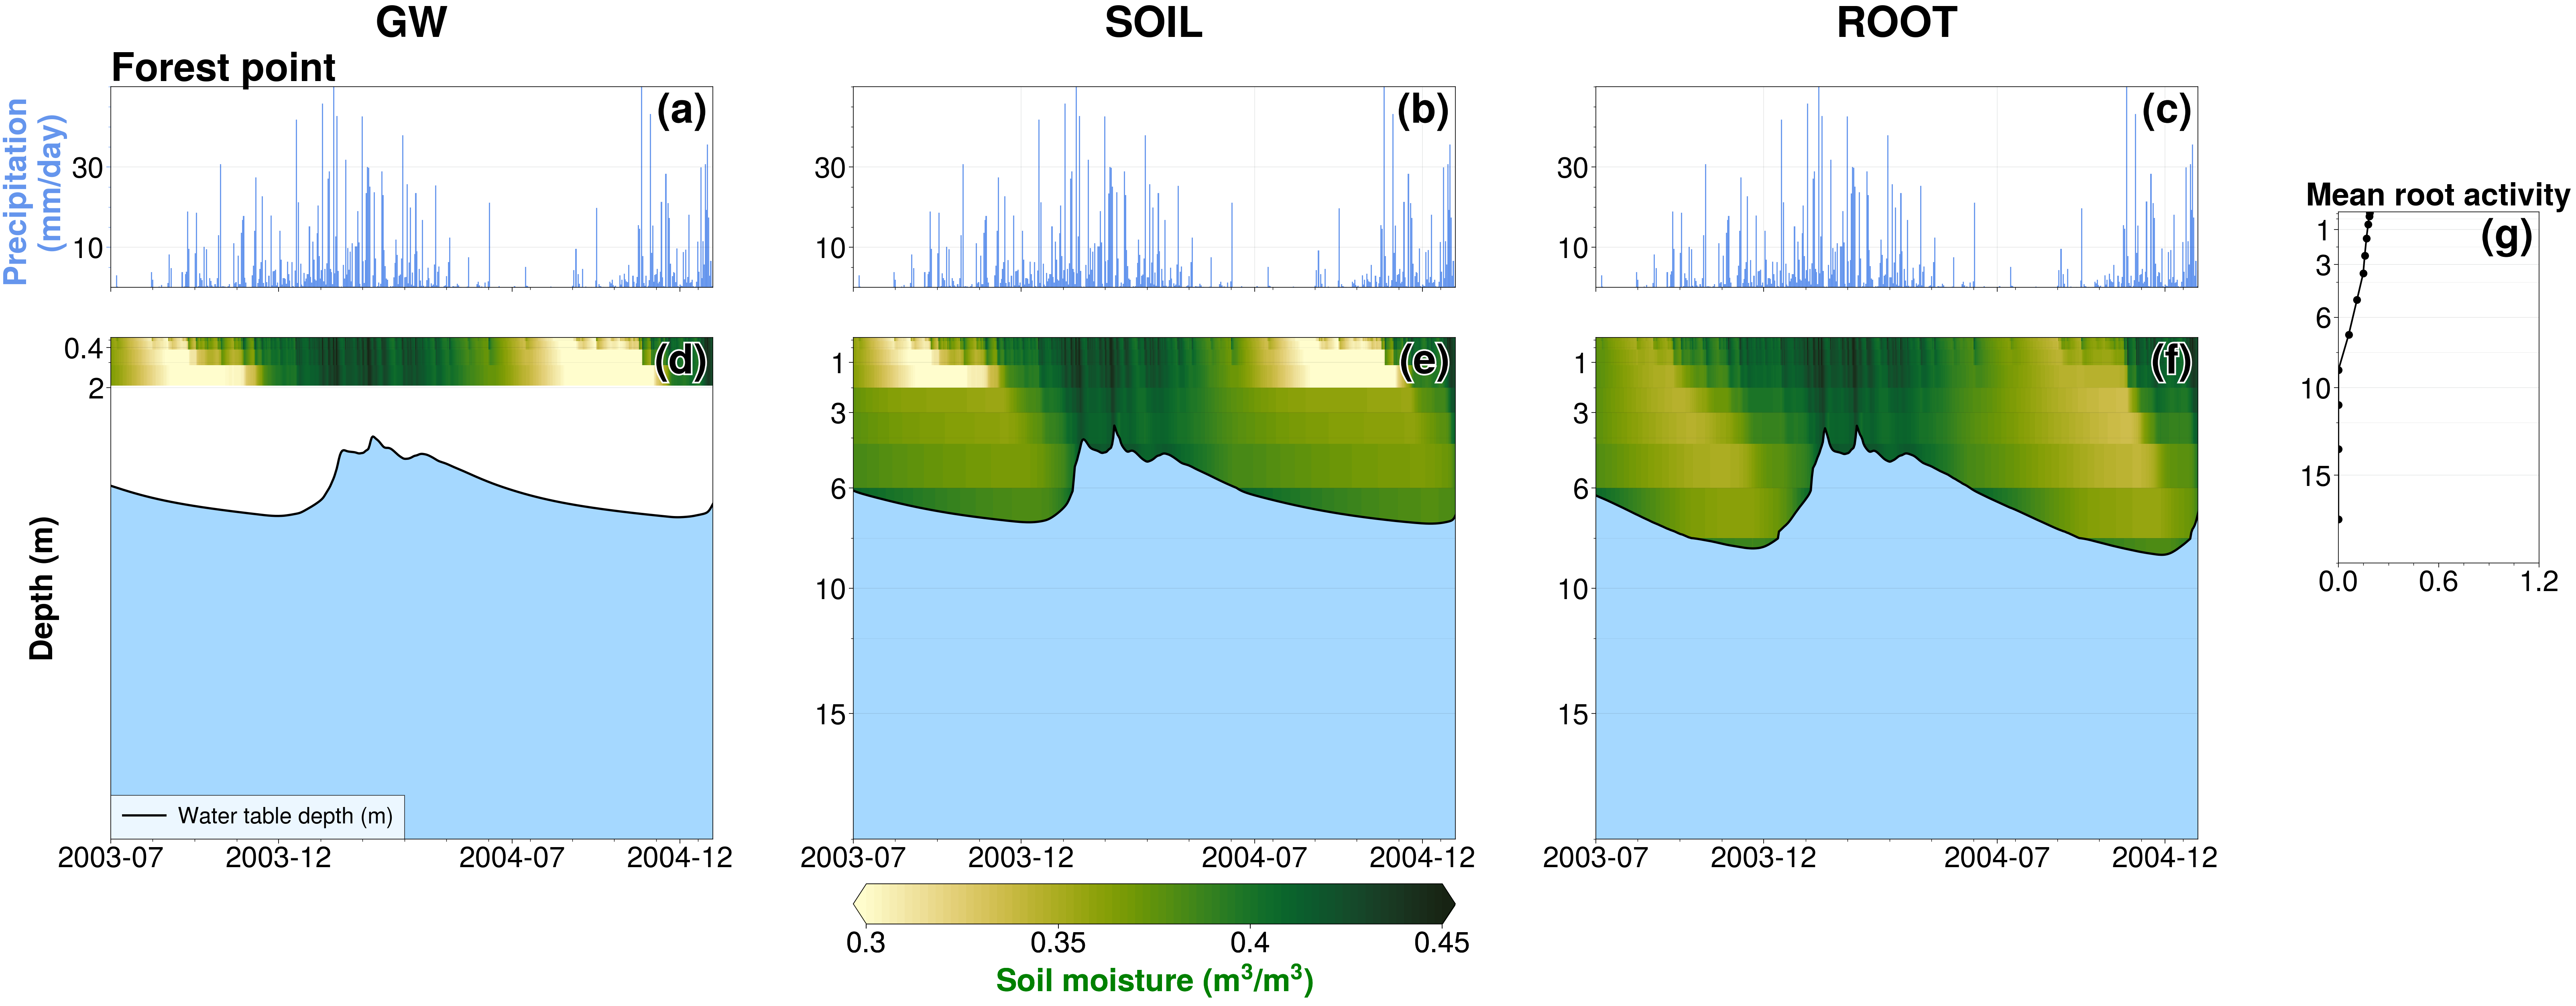

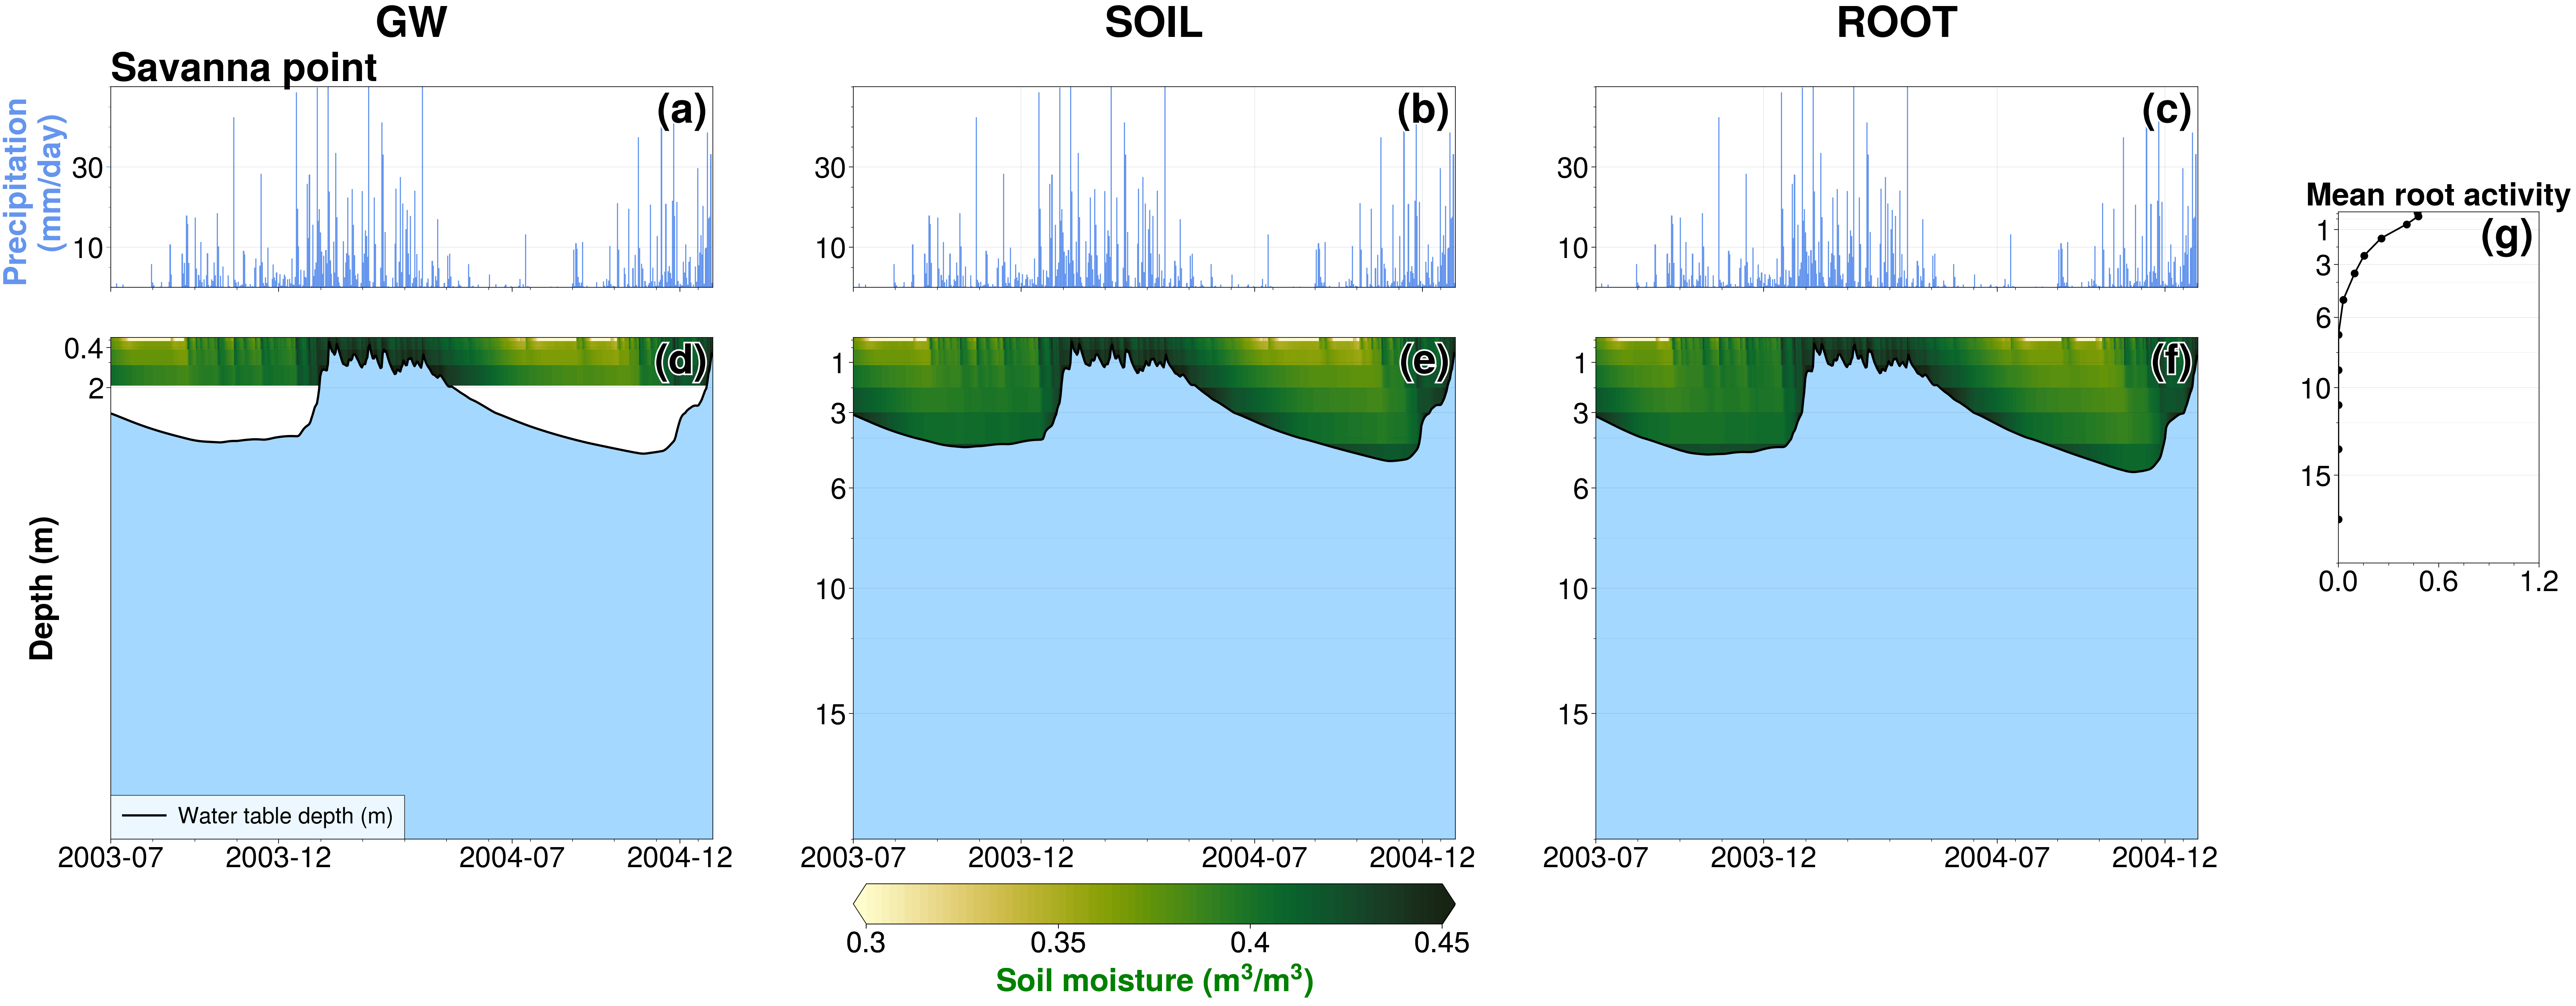

In [52]:
etpcpsm()

## Annual plots

In [53]:
# Calculate annual mean cycles
doyr = data['rootnew'][['ETRAN','EDIR','ECAN','LH','HFX']].groupby('date.dayofyear').mean('date')
doys = data['soil'][['ETRAN','EDIR','ECAN','LH','HFX']].groupby('date.dayofyear').mean('date')
doyf = data['fd'][['ETRAN','EDIR','ECAN','LH','HFX']].groupby('date.dayofyear').mean('date')
doyg = data['gw'][['ETRAN','EDIR','ECAN','LH','HFX']].groupby('date.dayofyear').mean('date')

In [55]:
pplt.rc['legend.fontsize'] = 15
def mean_fluxes():
    '''
    Function that plots annual mean cycles of transpiration, latent heat flux, canopy evaporation, ground evaporation, and sensible heat flux for a given grid point.
    Includes data from FD, GW, SOIL, and ROOT simulations.
    '''
    i=0
    pplt.rc['axes.prop_cycle'] = pplt.Cycle('hawaii_r', 4, left=0.2)
    for x, y in [(jbrx, jbry), (fnsx, fnsy)]:
        
        fig = pplt.figure(refwidth='50em', refheight='20em', spanx=False)
        axs = fig.subplots(nrows=5, ncols=1, wspace=3, hspace=0)
    
        time = doys['dayofyear'].values
    
        axs[0].plot(time, doyf['ETRAN'][:,x,y].values*86400., lw=2)
        axs[0].plot(time, doyg['ETRAN'][:,x,y].values*86400., lw=2, linestyle='-.')
        axs[0].plot(time, doys['ETRAN'][:,x,y].values*86400., lw=2, linestyle=':')
        axs[0].plot(time, doyr['ETRAN'][:,x,y].values*86400., lw=2, linestyle='--')
        axs[0].format(ylocator=[1,2,3], ylim=(0.2,4), xlim=(130,275), ultitle='Transpiration (mm/day)', yformatter='sci', 
                      titlesize=15)

        p1 = axs[1].plot(time, doyf['ECAN'][:,x,y].values*86400, lw=2, label='FD')
        p2 = axs[1].plot(time, doyg['ECAN'][:,x,y].values*86400, lw=2, linestyle='-.', label='GW')
        p3 = axs[1].plot(time, doys['ECAN'][:,x,y].values*86400, lw=2, linestyle=':',  label='Soil')
        p4 = axs[1].plot(time, doyr['ECAN'][:,x,y].values*86400, lw=2, linestyle='--', label='Root')
        #axs[1].legend(loc='r', ncols=1, fontsize=16)
        axs[1].format(ylim=(-0.1,4), ylocator=[1,2,3], ultitle='Canopy evaporation (mm/day)', titlesize=15)
        
        axs[2].plot(time, doyf['EDIR'][:,x,y].values*86400, lw=2)
        axs[2].plot(time, doyg['EDIR'][:,x,y].values*86400, lw=2, linestyle='-.')
        axs[2].plot(time, doys['EDIR'][:,x,y].values*86400, lw=2, linestyle=':')
        axs[2].plot(time, doyr['EDIR'][:,x,y].values*86400, lw=2, linestyle='--')
        axs[2].format(ylim=(-0.1,4), ylocator=[1,2,3], ultitle='Ground evaporation (mm/day)', titlesize=15)
        
        
        axs[3].plot(time, doyf['LH'][:,x,y].values, lw=2)
        axs[3].plot(time, doyg['LH'][:,x,y].values, lw=2, linestyle='-.')
        axs[3].plot(time, doys['LH'][:,x,y].values, lw=2, linestyle=':')
        axs[3].plot(time, doyr['LH'][:,x,y].values, lw=2, linestyle='--')
        axs[3].format(ylim=(15, 138),
                      ylocator=[40,80,120], ultitle='Latent heat flux ($W/m^2$)', titlesize=15, xlabel='Day of year')
        
        axs[4].plot(time, doyf['HFX'][:,x,y].values, lw=2)
        axs[4].plot(time, doyg['HFX'][:,x,y].values, lw=2, linestyle='-.')
        axs[4].plot(time, doys['HFX'][:,x,y].values, lw=2, linestyle=':')
        axs[4].plot(time, doyr['HFX'][:,x,y].values, lw=2, linestyle='--')
        axs[4].format(ylim=(15, 90), ylocator=[20,50,80], ultitle='Sensible heat flux ($W/m^2$)', titlesize=14)
        
        fig.format(xlabelsize=16, xgrid=False, ygrid=False, yticklabelsize=14, xticklabelsize=15, abc='(a)',abcloc='ul', 
                   abcsize=14)
        fig.legend([p1, p2, p3, p4], loc='r', center=True, ncols=1, fontsize=30)
        axs[0].set_title(site_labels[i], weight='bold', loc='left', size=18)
        
        i += 1
        plt.savefig('flux' + str(i) + '.png')
        plt.show()

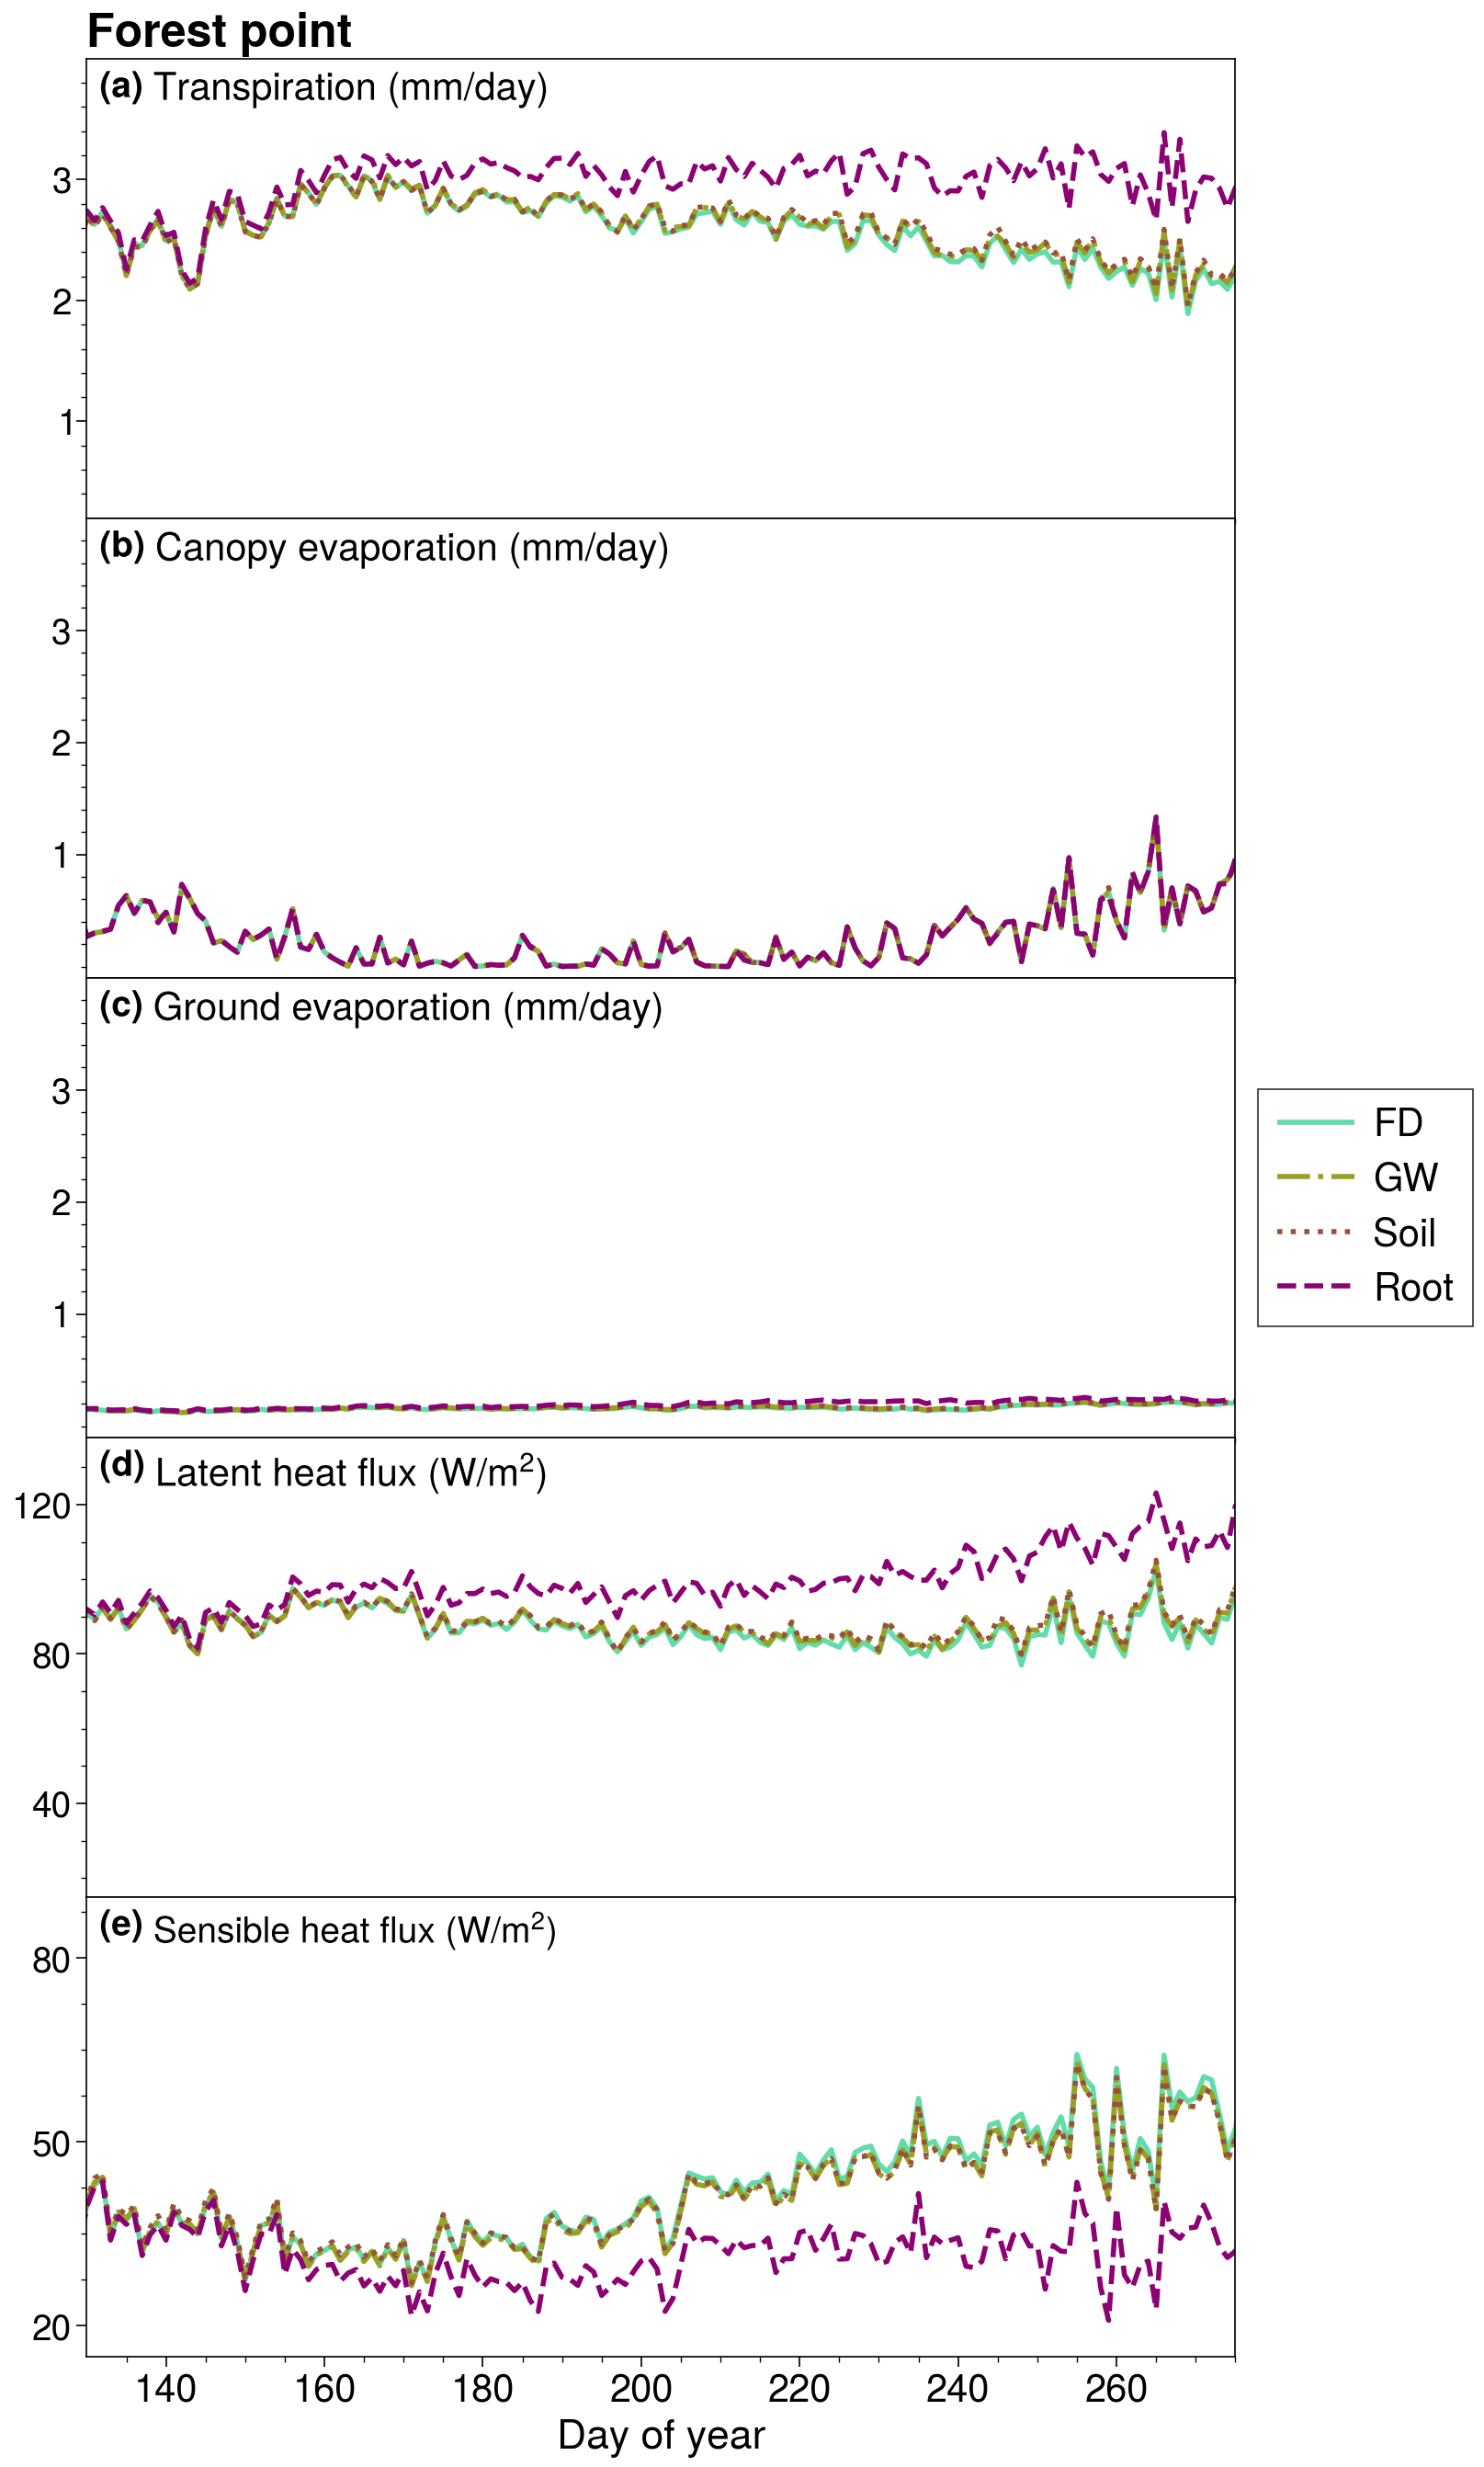

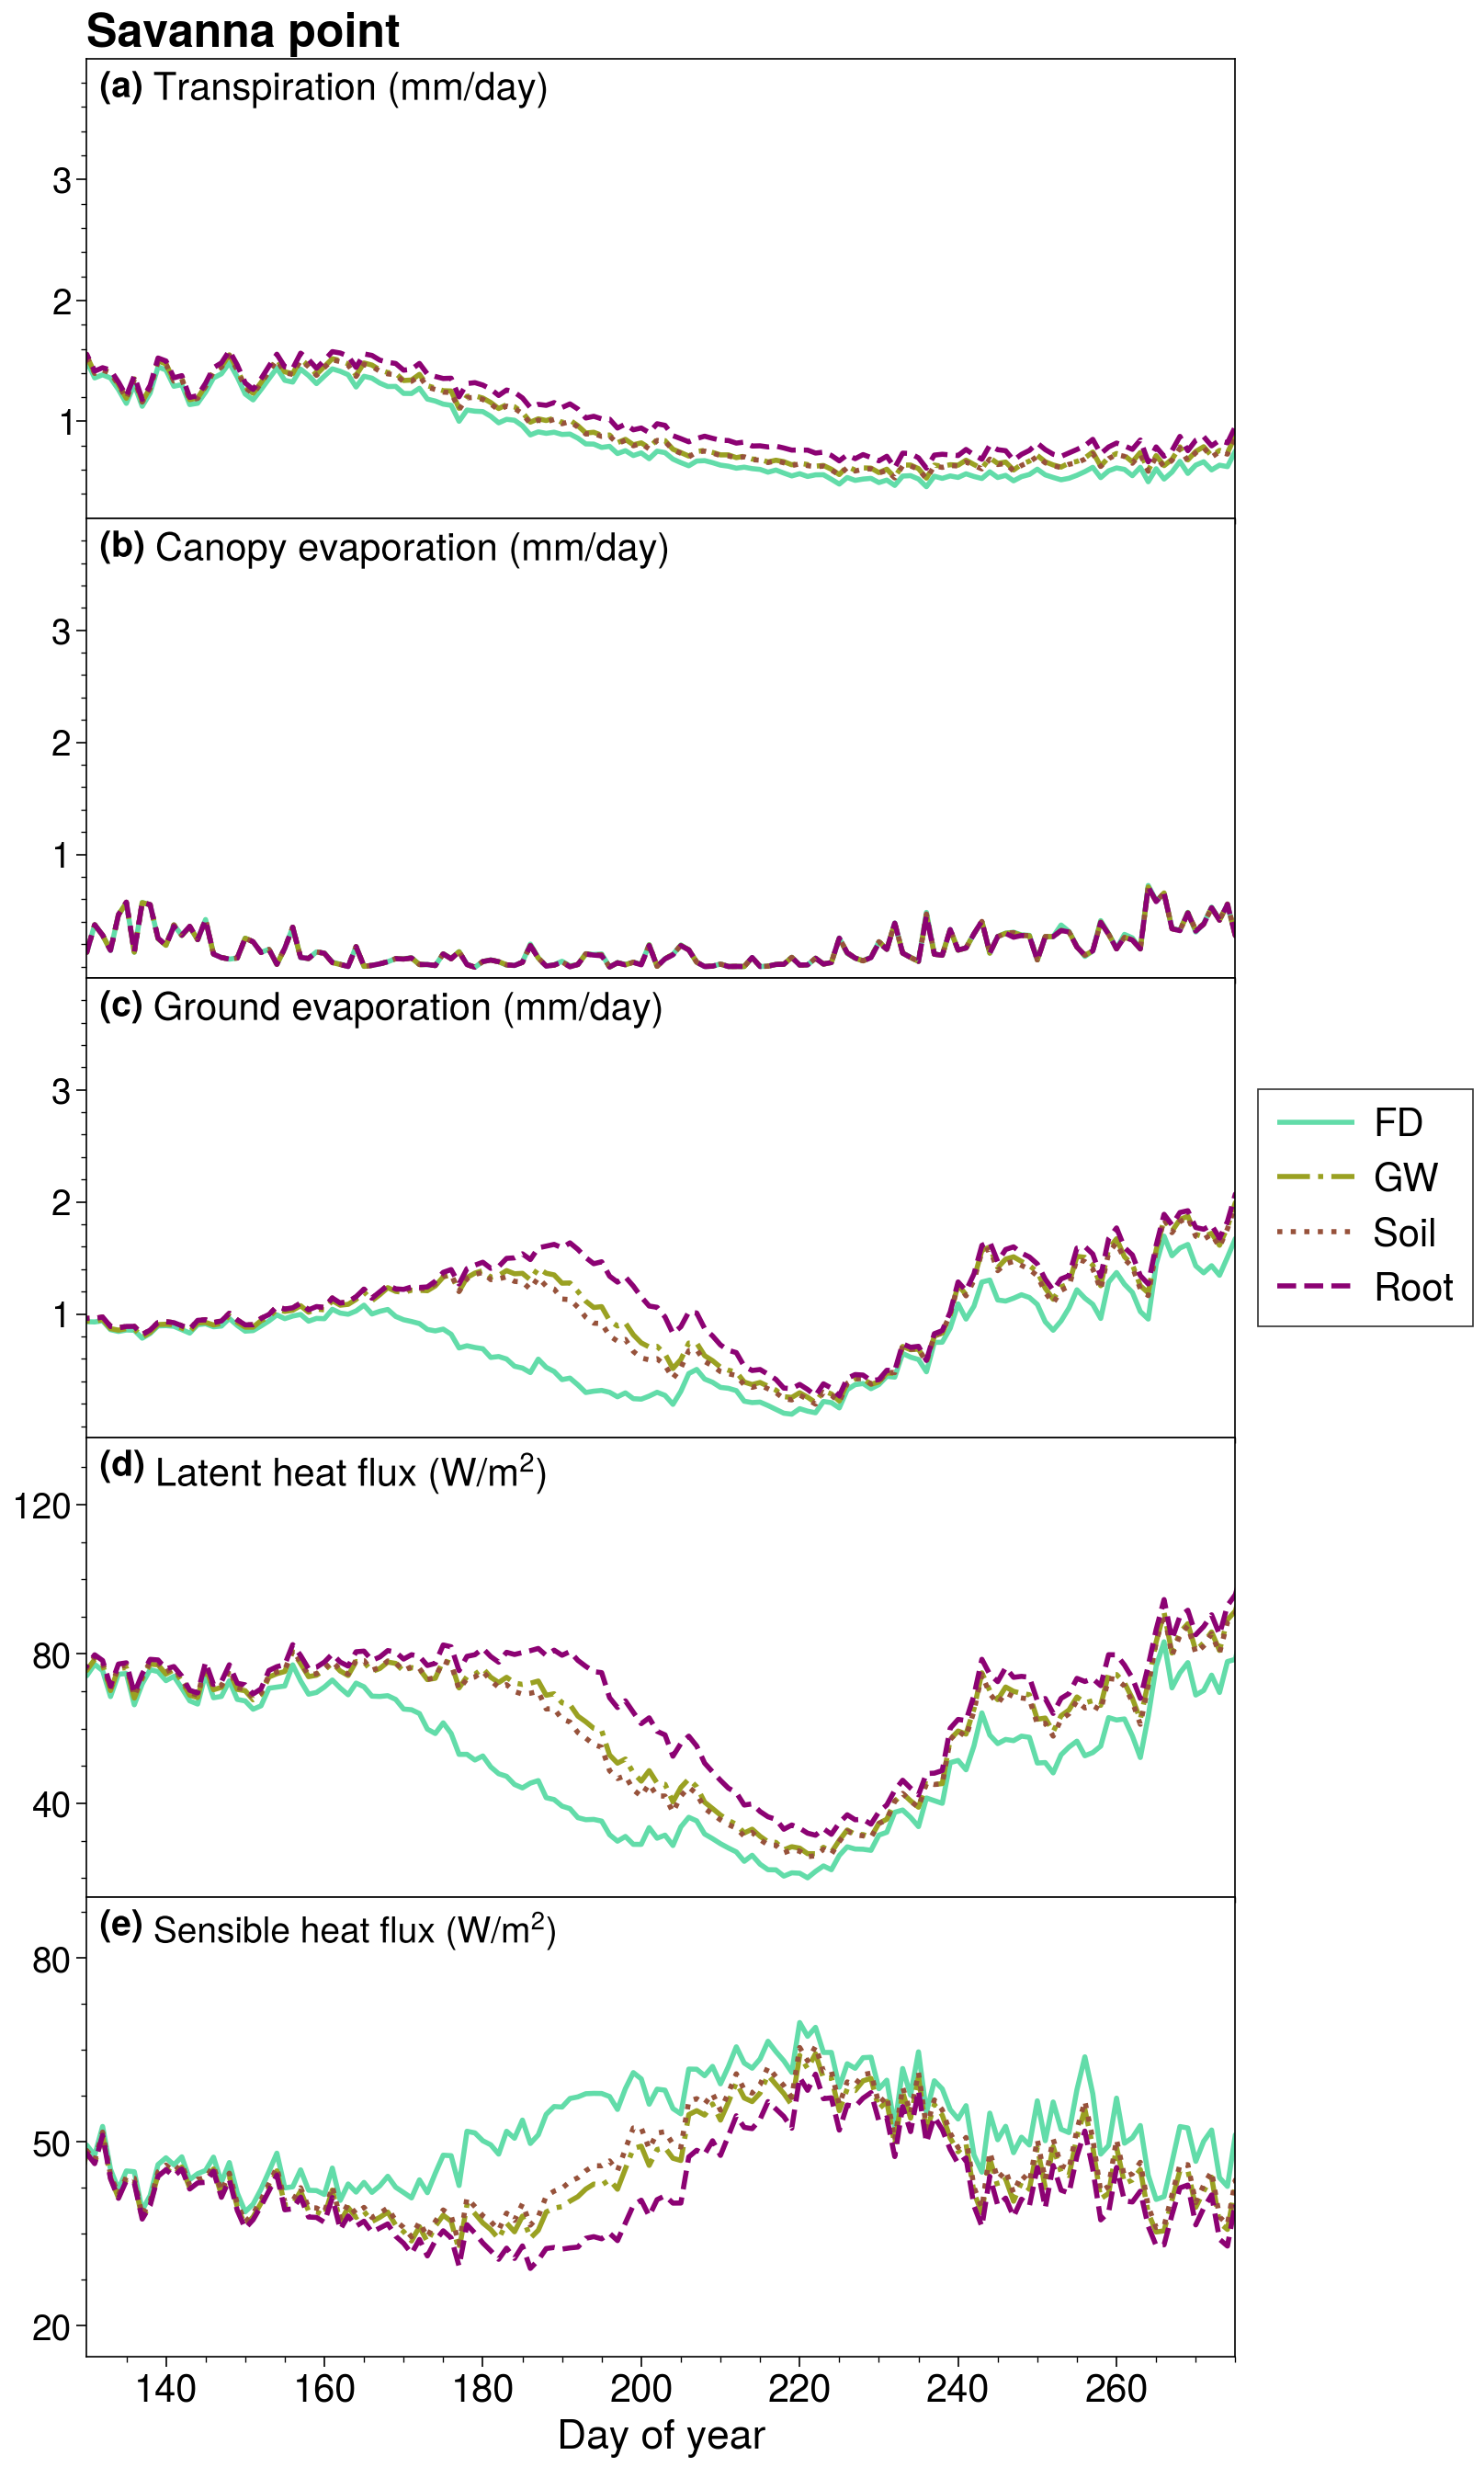

In [56]:
mean_fluxes()

In [57]:
pplt.rc['legend.fontsize'] = 11
def plot_uptake():
    '''
    Function that calculates and plots annual mean cycles of root water uptake and precipitation for different soil layers for a given grid point.
    '''
    i=0
    doyr = data['rootnew'][['QRAIN','UPTAKE']].groupby('date.dayofyear').mean('date')
    
    for x, y in [(jbrx, jbry), (fnsx, fnsy)]:
        fig = pplt.figure(refwidth='50em', refheight='15em')
        axs = fig.subplots(nrows=1, ncols=1)
    
        time = doyr['dayofyear'].values
        axs[0].bar(time, doyr['QRAIN'][:,x,y].values*86400., color='grey', width=1, alpha=0.5)
        axs[0].format(ylim=(0,15), ylabel='Precipitation (mm/day)',
                      ylabelsize=12, xgrid=False, ygrid=False)
    
        alty = axs[0].alty()
        p = alty.plot(time, doyr['UPTAKE'][:,x,y,:].values*86400.,cycle='romaO')
        alty.format(ylim=(0,1), ylabel='Uptake (mm/day)', ylabelsize=16, yticklabelsize=14)
    
        axs.format(xlim=(0,365), xlabel='Day of year', xlabelsize=16, ylabelsize=16, titlesize=18, titleweight='bold',
                   ltitle=site_labels[i], yticklabelsize=14, xticklabelsize=14)
        axs.legend(p, labels=['0.1 m','0.4 m','1 m','2 m','3 m','4 m','6 m','8 m'], loc='r', ncols=2)
        i+=1
        plt.savefig('uptake' + str(i) + '.png')
        plt.show()

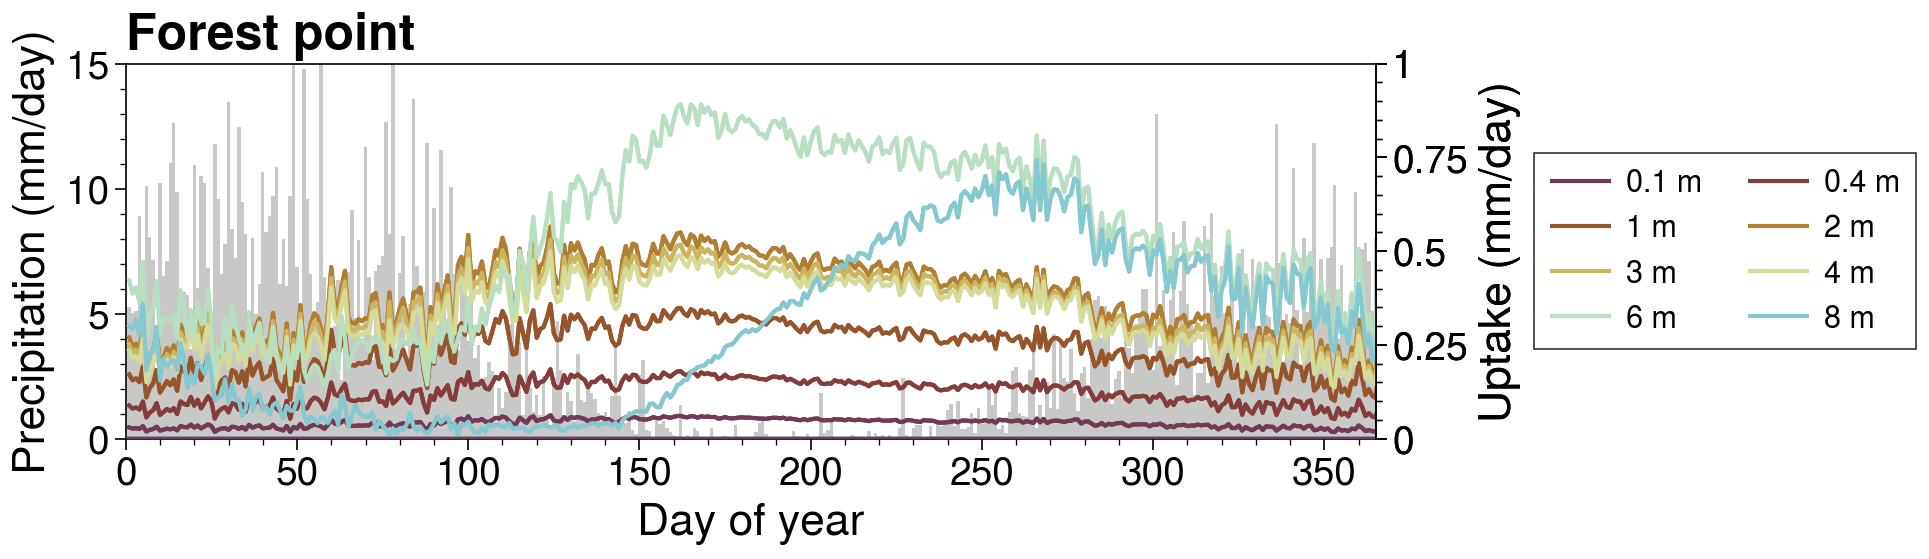

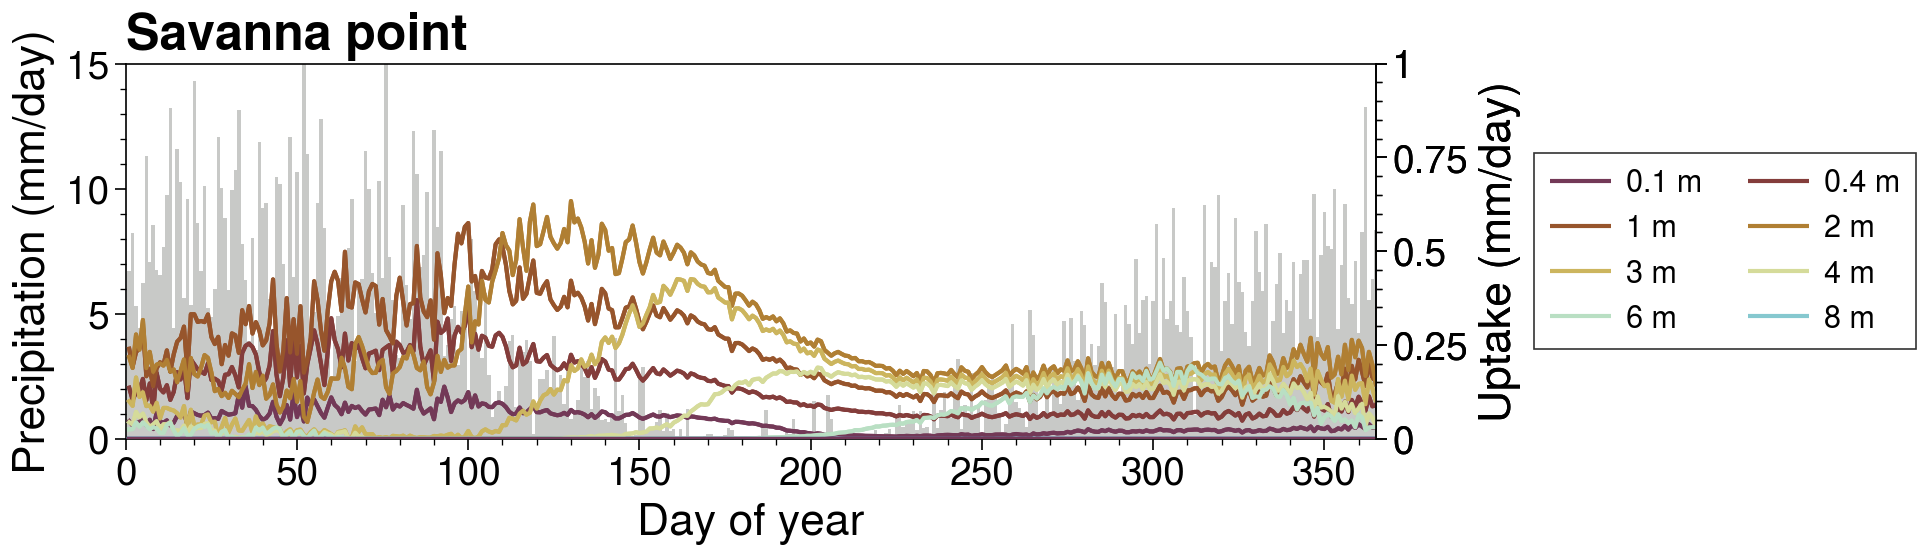

In [58]:
plot_uptake()

In [59]:
def sm_plot():
    '''
    Function that calculates and plots annual mean cycles of soil moisture for different soil layers for a given grid point. Includes data from GW, SOIL, and ROOT simulations.
    '''
    doyr = data['rootnew'][['QRAIN','SOIL_W']].groupby('date.dayofyear').mean('date')
    doys = data['soil'][['QRAIN','SOIL_W']].groupby('date.dayofyear').mean('date')
    doyg = data['gw'][['QRAIN','SOIL_W']].groupby('date.dayofyear').mean('date')
    i=0
    for x, y in [(jbrx, jbry), (fnsx, fnsy)]:

        cycle = pplt.Cycle('romaO', 9)
        if i==1:
            l=7
        else:
            l=8
        
        fig = pplt.figure(refwidth='45em', refheight='15em', spanx=True, sharey=True)
        axs = fig.subplots(nrows=1, ncols=3)
    
        time = doys['dayofyear'].values
        axs[0].bar(time, doyg['QRAIN'][:,x,y].values*86400., color='grey', width=1, alpha=0.5)
        axs[0].format(ylabel='Precipitation (mm/day)', titlesize=18,
                      ltitle=site_labels[i], titleweight='bold')
    
        alty = axs[0].alty()
        alty.plot(time, doyg['SOIL_W'][:,x,:,y],cycle=cycle)
        alty.format(ylim=(0.19,0.5), ylabel='', ylocator=[])
        
        axs[1].bar(time, doys['QRAIN'][:,x,y].values*86400., color='grey', width=1, alpha=0.5)
    
        alty = axs[1].alty()
        alty.plot(time, doys['SOIL_W'][:,x,:l,y],cycle=cycle)
        alty.format(ylim=(0.19,0.5), ylabel='', ylocator=[])
    
        axs[2].bar(time, doyr['QRAIN'][:,x,y].values*86400., color='grey', width=1, alpha=0.5)

        alty = axs[2].alty()
        p = alty.plot(time, doyr['SOIL_W'][:,x,:l,y],cycle=cycle)
        alty.format(ylim=(0.19,0.5), ylabel='Soil moisture $(m^{3}/m^{3})$', ylabelsize=18,
                   yticklabelsize=18)
        
        axs.format(xlim=(0,365), ylim=(0,15), xgrid=False, ygrid=False, xlabel='Day of year', xticklabelsize=18, 
                   yticklabelsize=18, ylabelsize=18, xlabelsize=20, toplabels=['GW','SOIL','ROOT'], toplabels_kw={'fontsize':24}, 
                   )
        
        fig.legend(p, labels=['0.1 m','0.4 m','1 m','2 m','3 m','4 m','6 m','8 m'], loc='r', ncols=2, label='')
        i+=1
        plt.savefig('sm' + str(i) + '.png')
        plt.show()

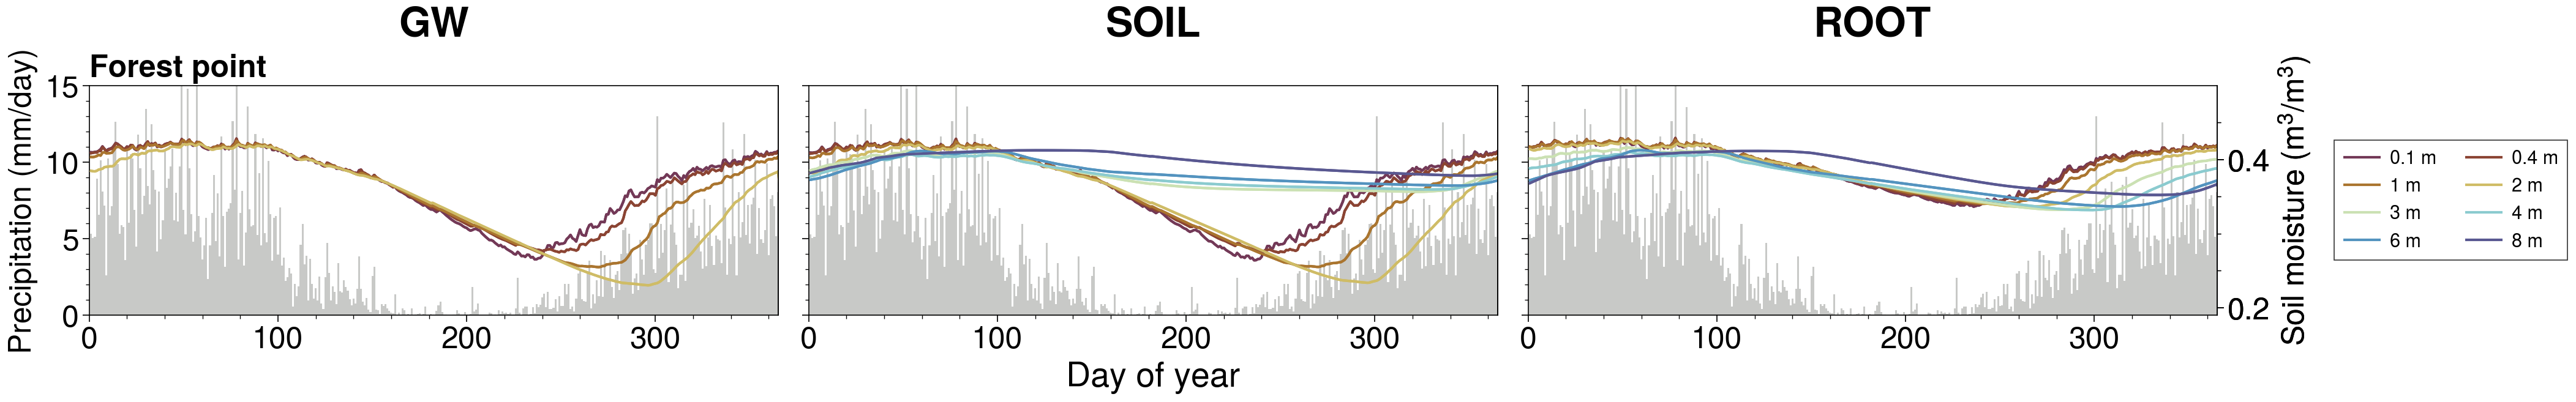

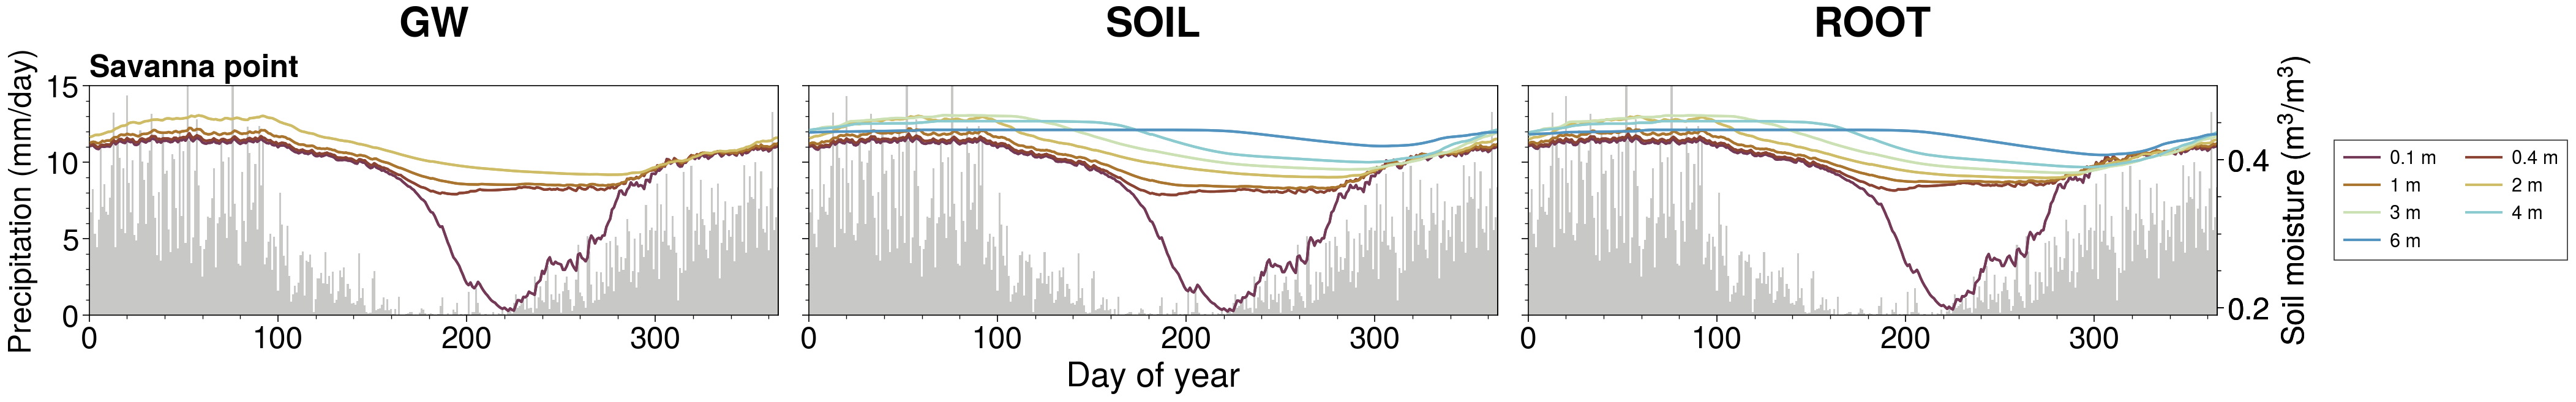

In [60]:
sm_plot()

## Area plots

In [61]:
# Calculate transpiration differences between different model experiments and the FD (control) case
diffr = data['rootnew']['ETRAN']-data['fd']['ETRAN']
diffs = data['soil']['ETRAN']-data['fd']['ETRAN']
diffg = data['gw']['ETRAN']-data['fd']['ETRAN']

In [62]:
# Calculate seasonal mean differences
sdiffr = diffr.groupby('date.season').mean('date')
sdiffs = diffs.groupby('date.season').mean('date')
sdiffg = diffg.groupby('date.season').mean('date')

In [63]:
# Calculate SON mean transpiration for FD case
fd_son = (data['fd']['ETRAN'].where(data['fd']['ETRAN'] > 0)).groupby('date.season').mean('date').sel(season='SON')

In [64]:
# Calculate percent difference in mean SON trnaspiration for whole domain
pct_diff = sdiffr.sel(season='SON')/fd_son

In [65]:
# Calculate domain mean percent difference
pct_diff.mean(dim='lat').mean(dim='lon')*100

<xarray.DataArray 'ETRAN' ()>
array(28.77596617)
Coordinates:
    season   <U3 'SON'

In [66]:
# Convert to actual ET 
chng = fd_son.mean('lat').mean('lon')*.274276197

In [67]:
chng*86400

<xarray.DataArray 'ETRAN' ()>
array(0.45636849)
Coordinates:
    season   <U3 'SON'

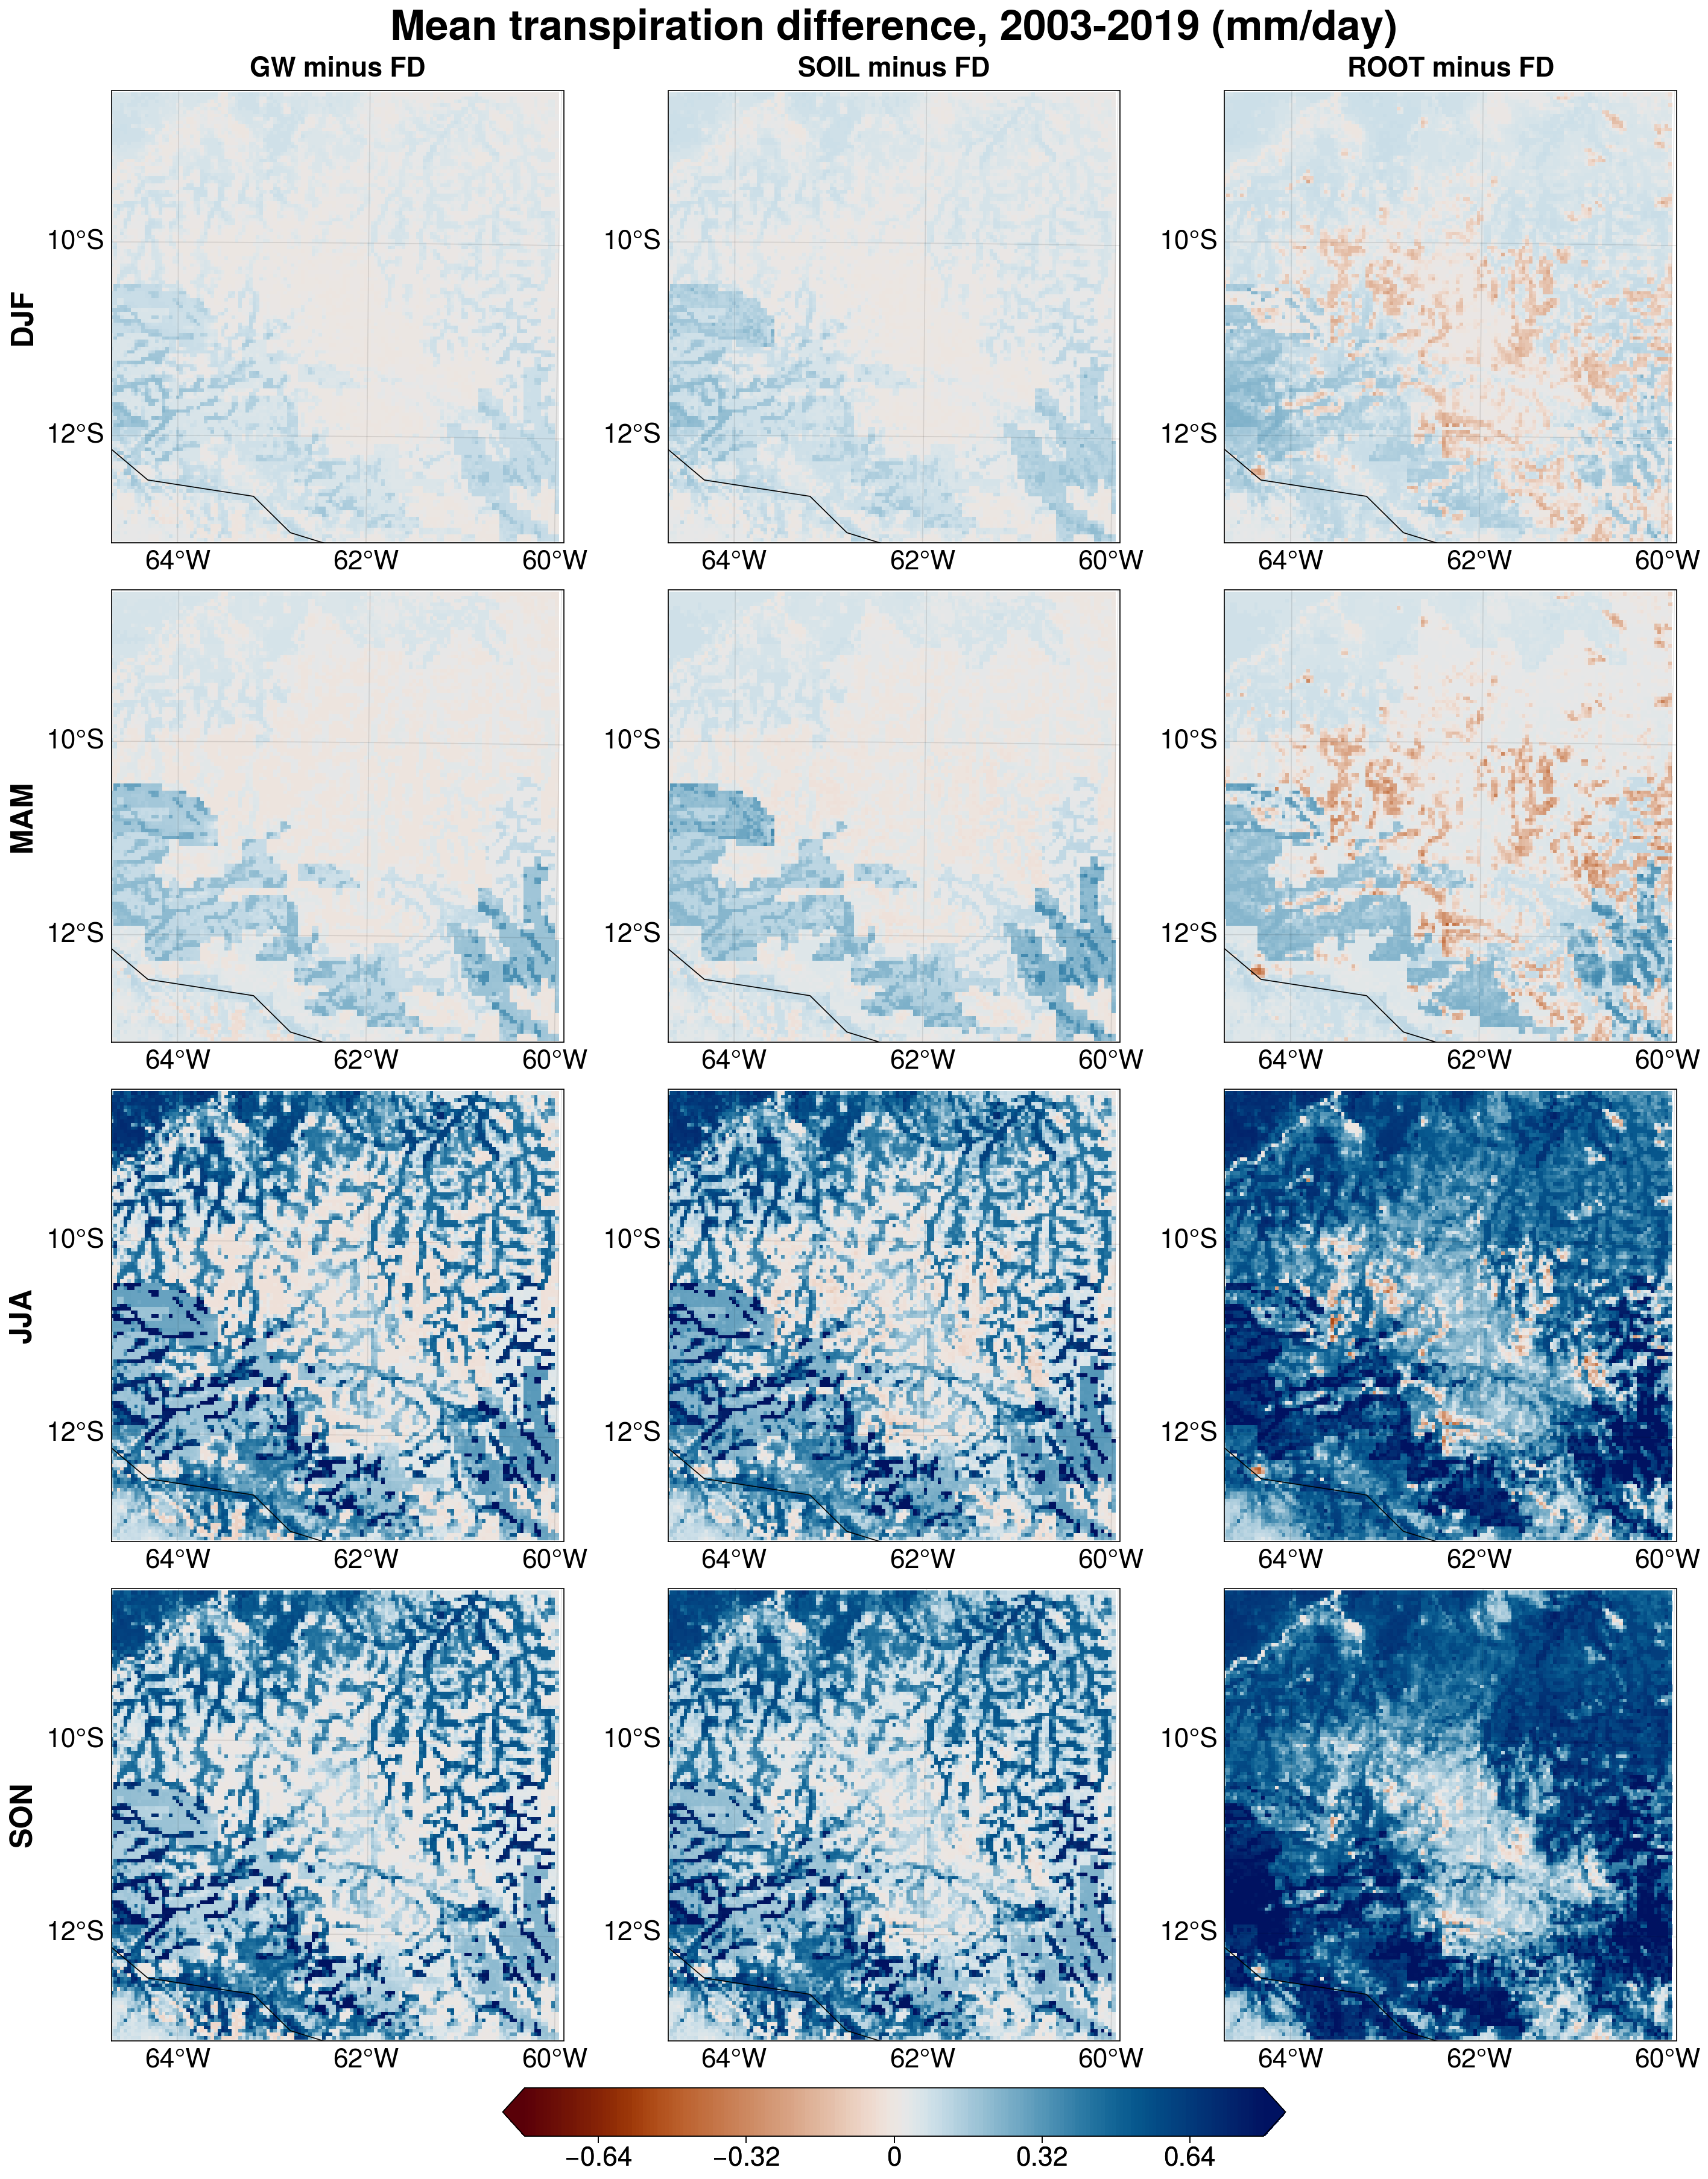

In [243]:
# Plot seasonal mean transpiration differences for GW minus FD, SOIL minus FD, and ROOT minus FD

# Create a figure
fig = pplt.figure(refwidth='30em', sharex=True, sharey=True)
# Set the GeoAxes to the projection used by WRF
ax = fig.subplots(nrows=4, ncols=3, projection=cart_proj)

seasons = ['DJF','MAM','JJA','SON']

for i in range(4):
    
    pc = ax[i, 0].pcolormesh(to_np(lons), to_np(lats), sdiffg.sel(season=seasons[i]).values*86400., 
                cmap='vik_r', transform=crs.PlateCarree(), vmin=-0.80,vmax=0.80, shading='auto',  levels=200,
                extend='both')
    
    pc = ax[i, 1].pcolormesh(to_np(lons), to_np(lats), sdiffs.sel(season=seasons[i]).values*86400., 
                    cmap='vik_r', transform=crs.PlateCarree(), vmin=-0.80,vmax=0.80, shading='auto',  levels=200,
                    extend='both')
    
    pc = ax[i, 2].pcolormesh(to_np(lons), to_np(lats), sdiffr.sel(season=seasons[i]).values*86400., 
                cmap='vik_r', transform=crs.PlateCarree(), vmin=-0.80,vmax=0.80, shading='auto', levels=200, 
                extend='both')

fig.colorbar(pc, loc='b', shrink=0.5, width=0.4, ticks=0.32, ticklabelsize=16)
fig.format(borders=True, lonlim=(lons.min(),lons.max()), latlim=(lats.min(), lats.max()), 
           labels=True, lonlocator=(pplt.Locator('fixed',(-60,-62,-64))), latlocator=(pplt.Locator('fixed',(-10,-12))), leftlabels=seasons, 
           toplabels=('GW minus FD','SOIL minus FD','ROOT minus FD'), toplabelsize=16,
           leftlabelsize=18, suptitle='Mean transpiration difference, 2003-2019 (mm/day)', suptitlesize=25, ticklabelsize=16)
   
plt.savefig('transdiff.png')
plt.show()

## Histograms

In [19]:
# Calculate mean WTD, mean dry month WTD, and mean wet month WTD

zwtmean = data['rootnew']['ZWT'].where(data['rootnew']['ZWT'] > -150).mean(dim='date')

zwtdry  = data['rootnew']['ZWT'].where(data['rootnew']['ZWT'] > -150).sel(date=is_jjas(data['rootnew']['date.month']))
zwtdry  = zwtdry.mean(dim='date')

zwtwet  = data['rootnew']['ZWT'].where(data['rootnew']['ZWT'] > -150).sel(date=is_ndjf(data['rootnew']['date.month']))
zwtwet  = zwtwet.mean(dim='date')

In [125]:
# Calculate mean dry month transpiration in mm/day
drytr = data['rootnew']['ETRAN'].sel(date=is_jjas(data['rootnew']['ETRAN']['date.month']))*86400.
dryts = data['soil']['ETRAN'].sel(date=is_jjas(data['soil']['ETRAN']['date.month']))*86400.

In [21]:
# Create DataFrame to hold different groupings of dry month transpiration
df = pd.DataFrame(data=np.asarray([drytr.values.flatten(),dryts.values.flatten()]).T, columns=['Root T','Soil T'])

In [22]:
df['Soil_Sav'] = dryts.where([luse==9]).values.flatten() # SOIL case, savanna points
df['Soil_For'] = dryts.where([luse==2]).values.flatten() # SOIL case, forest points

In [23]:
df['Root_Sav'] = drytr.where([luse==9]).values.flatten() # ROOT case, savanna points
df['Root_For'] = drytr.where([luse==2]).values.flatten() # ROOT case, forest points

In [24]:
df['ROOT'] = drytr.where([zwtdry>=-2.5]).values.flatten() # ROOT case, mean dry month WTD < 2.5 m
df['Root_Mid'] = drytr.where([(zwtdry<-2.5) & (zwtdry>=-20)]).values.flatten() # ROOT case, 2.5 m < mean dry month WTD < 20 m
df['Root_Hi']  = drytr.where([zwtdry<-20]).values.flatten() # ROOT case, mean dry month WTD > 20 m

In [25]:
df['SOIL'] = dryts.where([zwtdry>=-2.5]).values.flatten() # SOIL case, mean dry month WTD < 2.5 m
df['Soil_Mid'] = dryts.where([(zwtdry<-2.5) & (zwtdry>=-20)]).values.flatten() # SOIL case, 2.5 m < mean dry month WTD < 20 m
df['Soil_Hi']  = dryts.where([zwtdry<-20]).values.flatten() # SOIL case, mean dry month WTD > 20 m

In [27]:
# Fill missing values with NaNs
df[df < -1000] = np.NaN

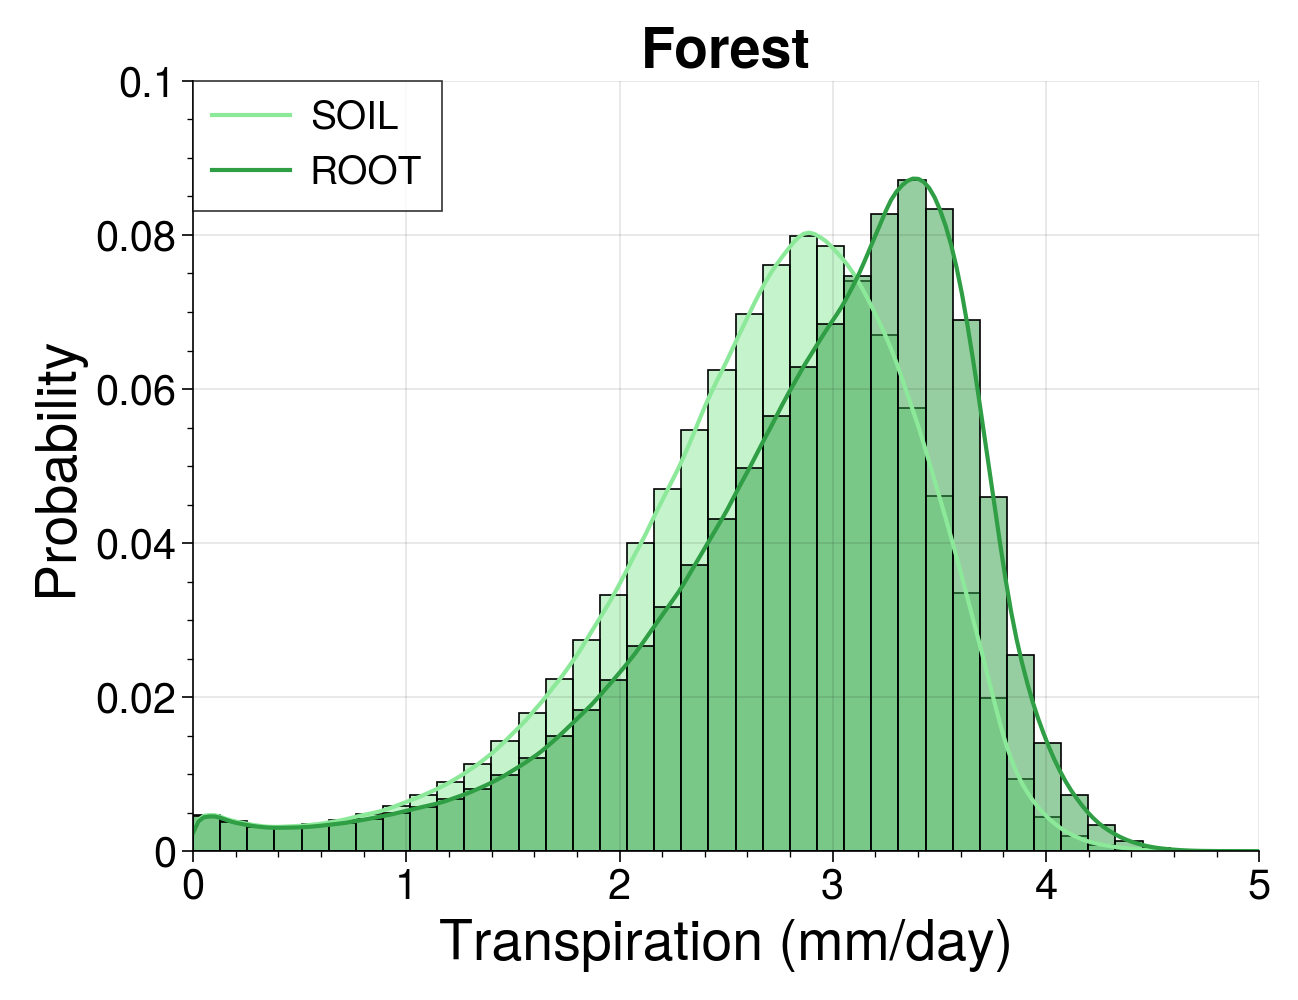

In [35]:
# Plot histograms of mean dry month transpiration for forest points in SOIL and ROOT cases

pplt.rc['legend.fontsize'] = 14
s = sns.displot(df[['Root_For','Soil_For']], kind='hist', common_norm=False, 
            stat='probability', bins=40, kde=True, palette=['green8','green3'])
plt.ylabel('Probability', size=20)
plt.xlabel('Transpiration (mm/day)', size=20)
s.set(xlim=(0,5))
s.set(ylim=(0,0.1))
s._legend.remove()
plt.title('Forest', size=20, weight='bold')
# Plot using seaborn
plt.tight_layout()
plt.legend(loc='upper left', labels=['SOIL', 'ROOT'])
s.set_yticklabels(size = 15)
s.set_xticklabels(size = 15)
plt.show()

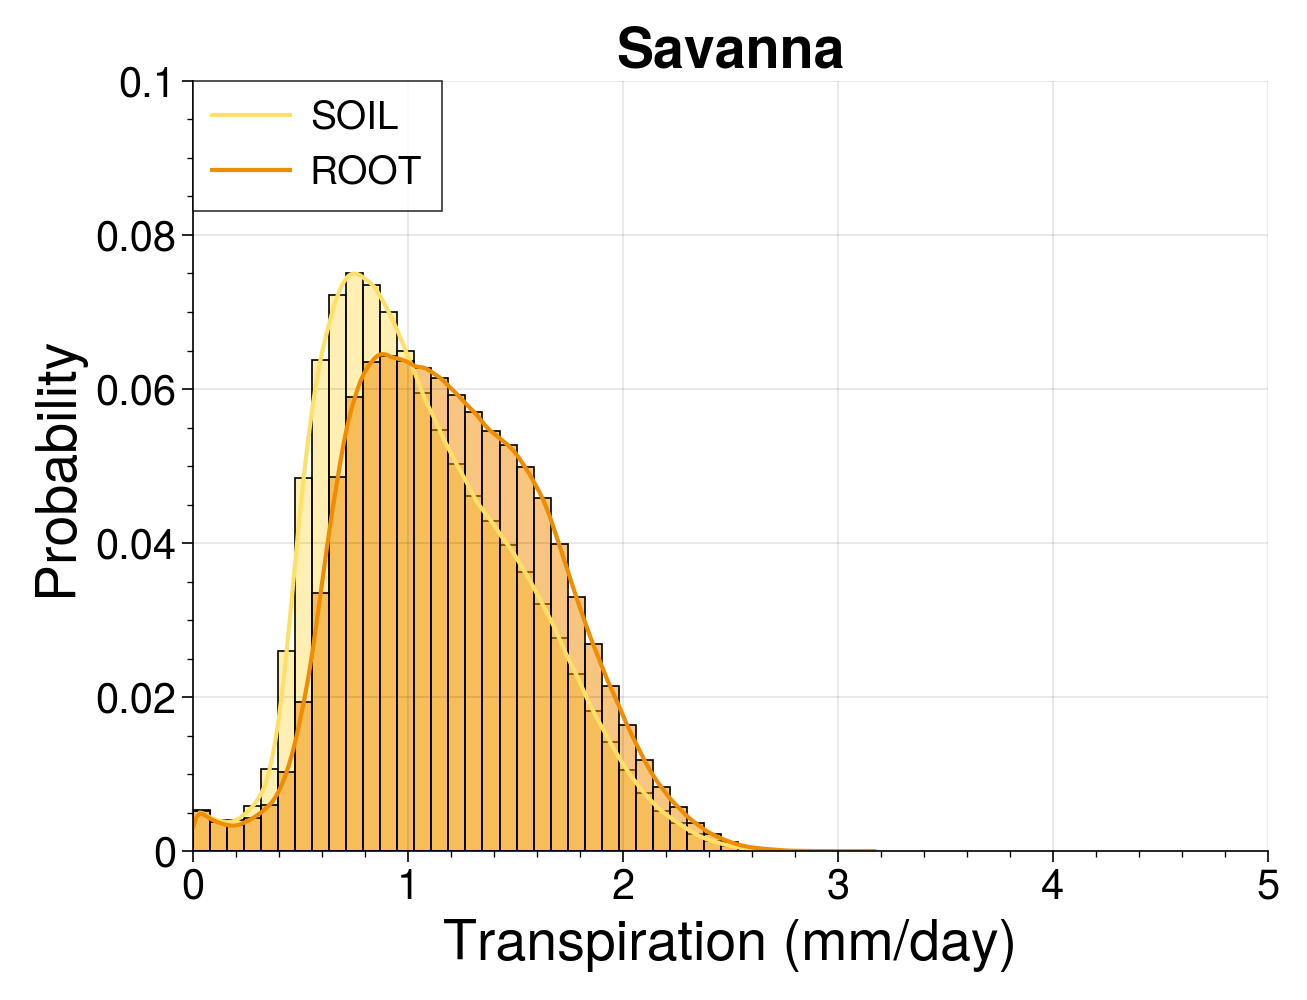

In [36]:
# Plot histograms of mean dry month transpiration for savanna points in SOIL and ROOT cases

pplt.rc['legend.fontsize'] = 14
s = sns.displot(df[['Root_Sav','Soil_Sav']], kind='hist', common_norm=False, 
            stat='probability', bins=40, kde=True, palette=['yellow8','yellow3'])
plt.ylabel('Probability', size=20)
plt.xlabel('Transpiration (mm/day)', size=20)
s.set(xlim=(0,5))
s.set(ylim=(0,0.1))
s._legend.remove()
plt.title('Savanna', size=20, weight='bold')
plt.tight_layout()
plt.legend(loc='upper left', labels=['SOIL', 'ROOT'])
s.set_yticklabels(size = 15)
s.set_xticklabels(size = 15)
plt.show()

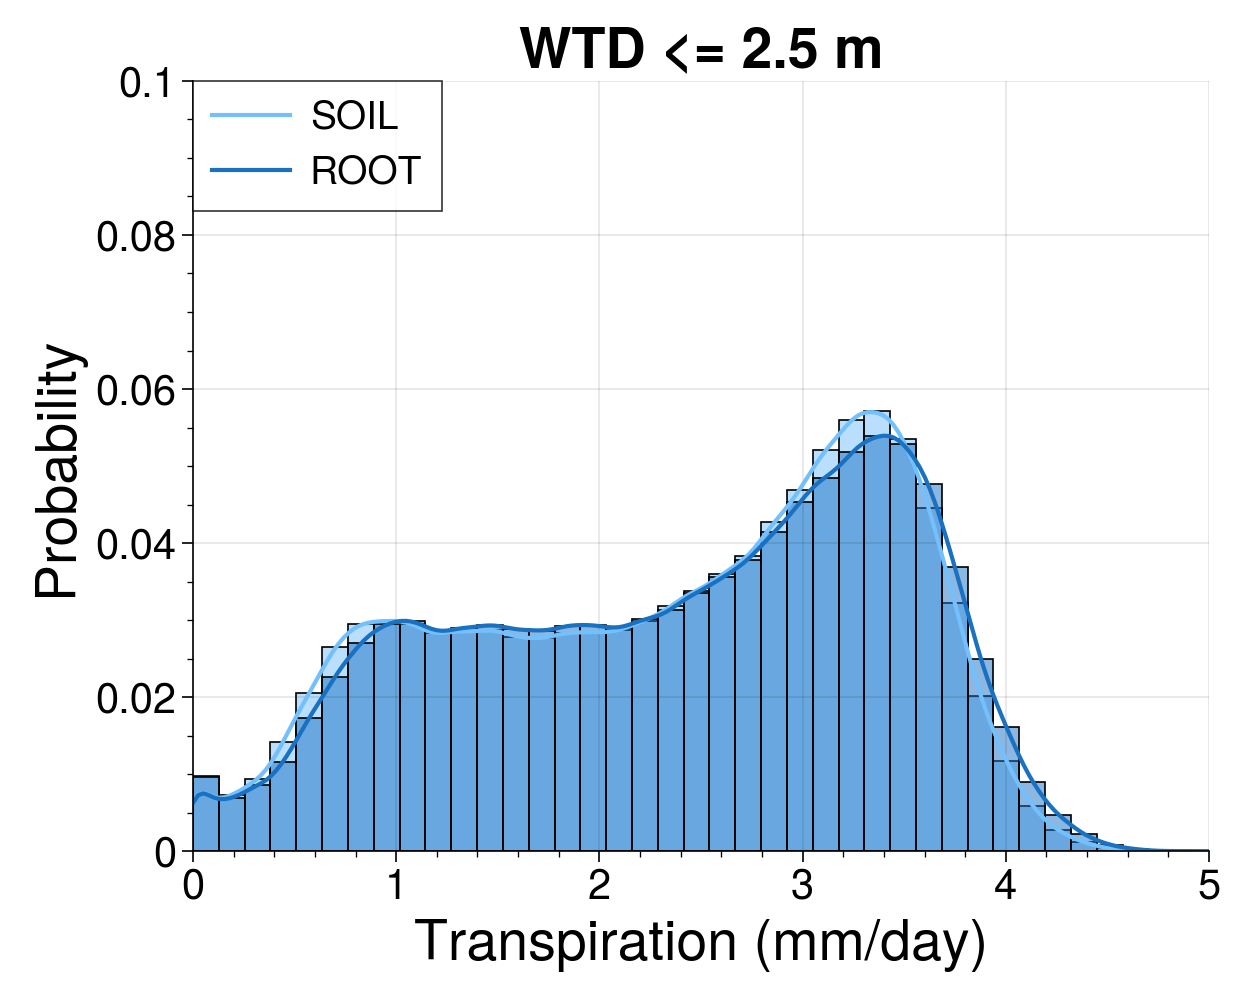

In [37]:
# Plot histograms of mean dry month transpiration for points with dry month WTD <= 2.5 m in SOIL and ROOT cases

s = sns.displot(df[['ROOT','SOIL']], kind='hist',common_norm=False, 
            stat='probability', bins=40, kde=True, palette=['blue8','blue3'])
plt.ylabel('Probability', size=20)
plt.xlabel('Transpiration (mm/day)', size=20)
s.set(xlim=(0,5))
s.set(ylim=(0,0.1))
s._legend.remove()
plt.title('WTD <= 2.5 m', size=20, weight='bold')
plt.tight_layout()
plt.legend(loc='upper left', labels=['SOIL', 'ROOT'])
s.set_yticklabels(size = 15)
s.set_xticklabels(size = 15)
plt.show()

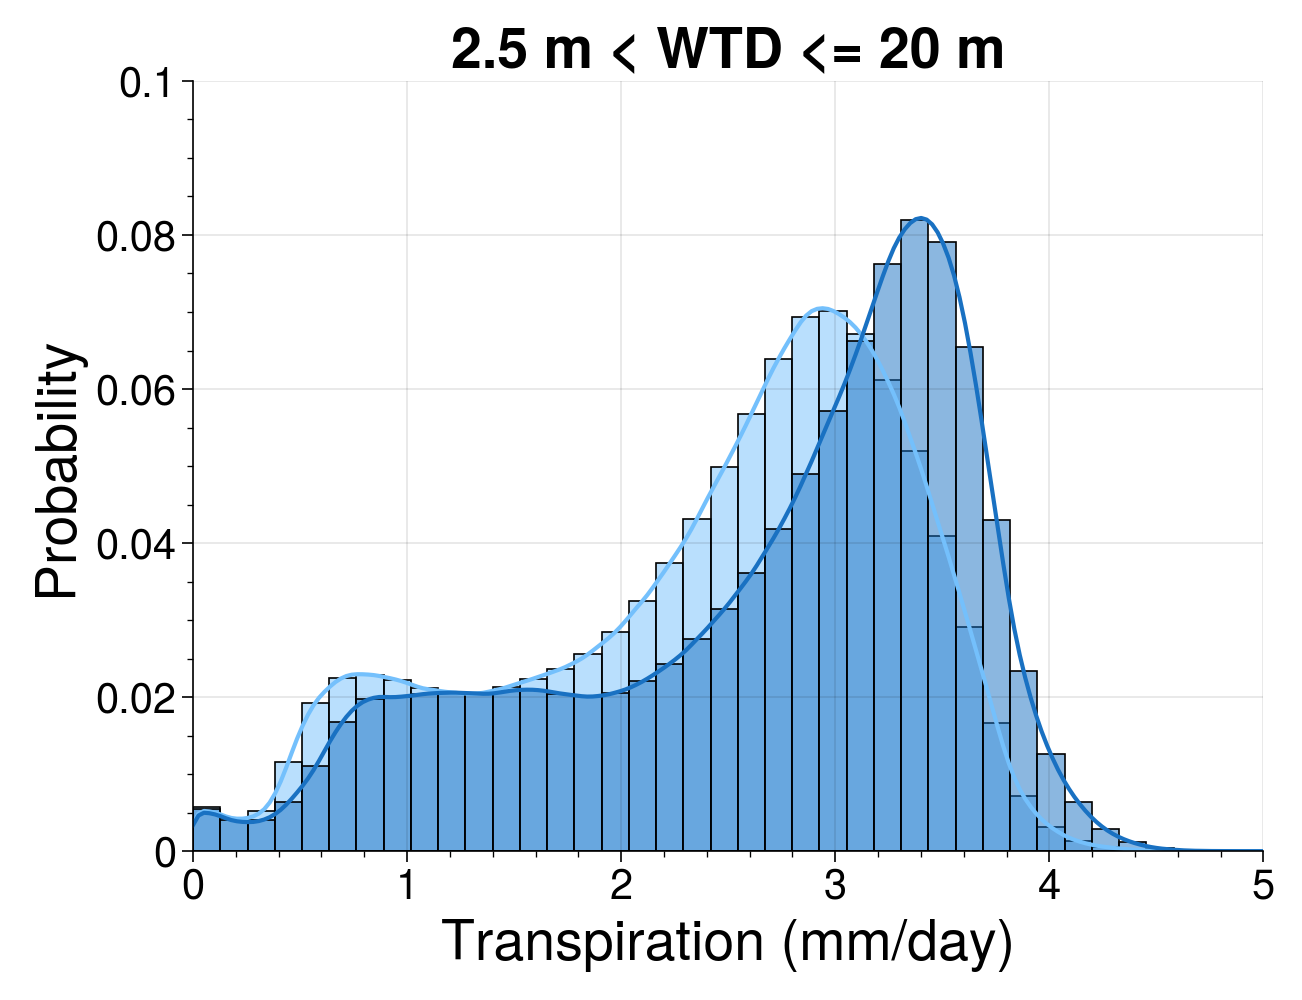

In [38]:
# Plot histograms of mean dry month transpiration for points with dry month 2.5 m < WTD <= 20 m in SOIL and ROOT cases

s = sns.displot(df[['Root_Mid','Soil_Mid']], kind='hist', common_norm=False, 
            stat='probability', bins=40, kde=True, palette=['blue8','blue3'])
plt.ylabel('Probability', size=20)
plt.xlabel('Transpiration (mm/day)', size=20)
s.set(xlim=(0,5))
s.set(ylim=(0,0.1))
s._legend.remove()
plt.title('2.5 m < WTD <= 20 m', size=20, weight='bold')
plt.tight_layout()
s.set_yticklabels(size = 15)
s.set_xticklabels(size = 15)
plt.show()

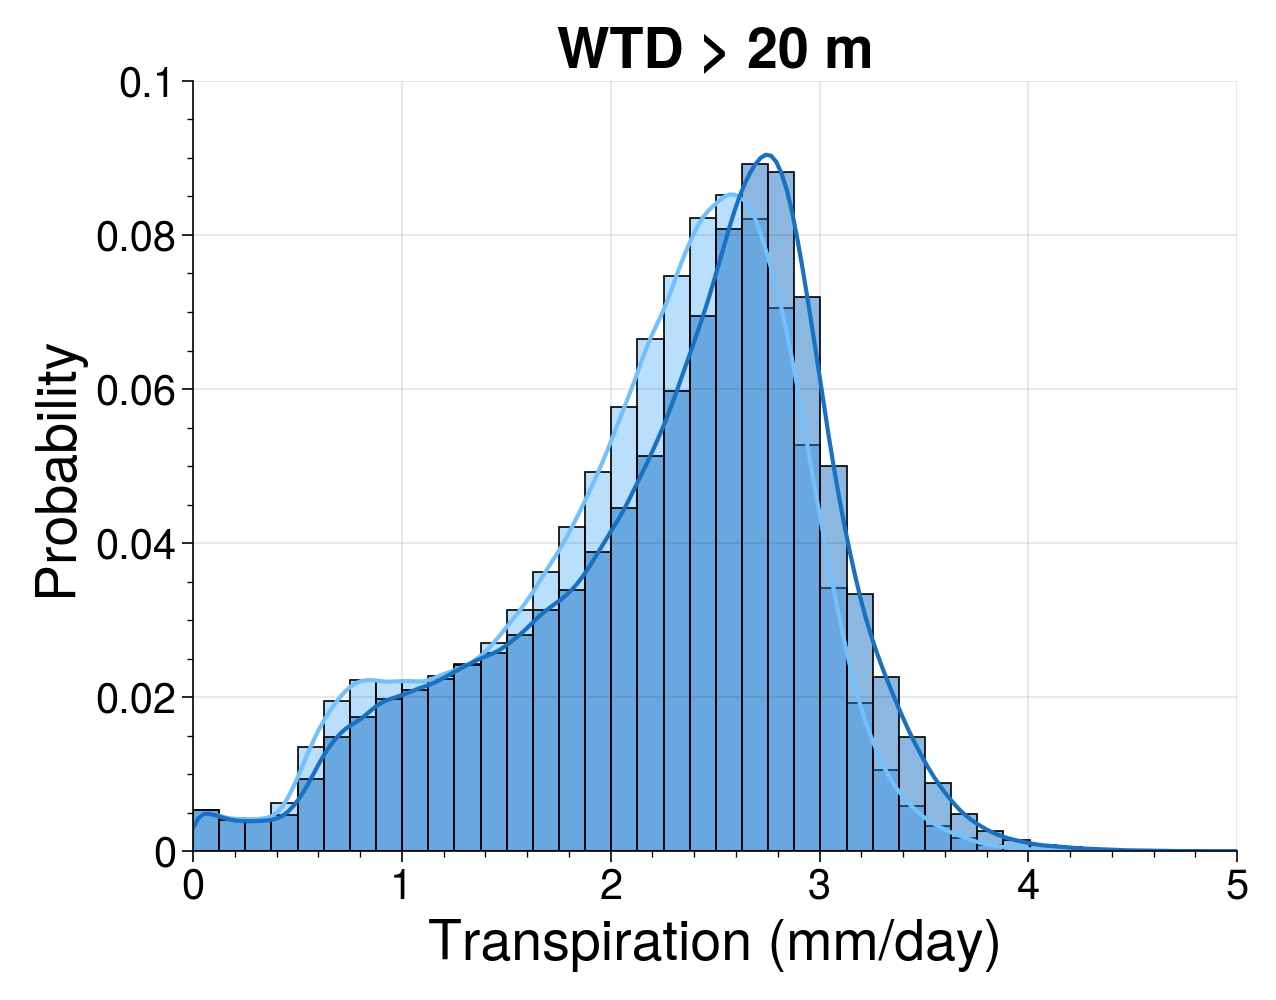

In [39]:
# Plot histograms of mean dry month transpiration for points with dry month WTD > 20 m in SOIL and ROOT cases

s = sns.displot(df[['Root_Hi','Soil_Hi']], kind='hist', common_norm=False, 
            stat='probability', bins=40, kde=True, palette=['blue8','blue3'])
plt.ylabel('Probability', size=20)
plt.xlabel('Transpiration (mm/day)', size=20)
s.set(xlim=(0,5))
s.set(ylim=(0,0.1))
s._legend.remove()
plt.title('WTD > 20 m', size=20, weight='bold')
plt.tight_layout()
s.set_yticklabels(size = 15)
s.set_xticklabels(size = 15)
plt.show()

## Additional area plots

In [32]:
markercolors = ['black','red']

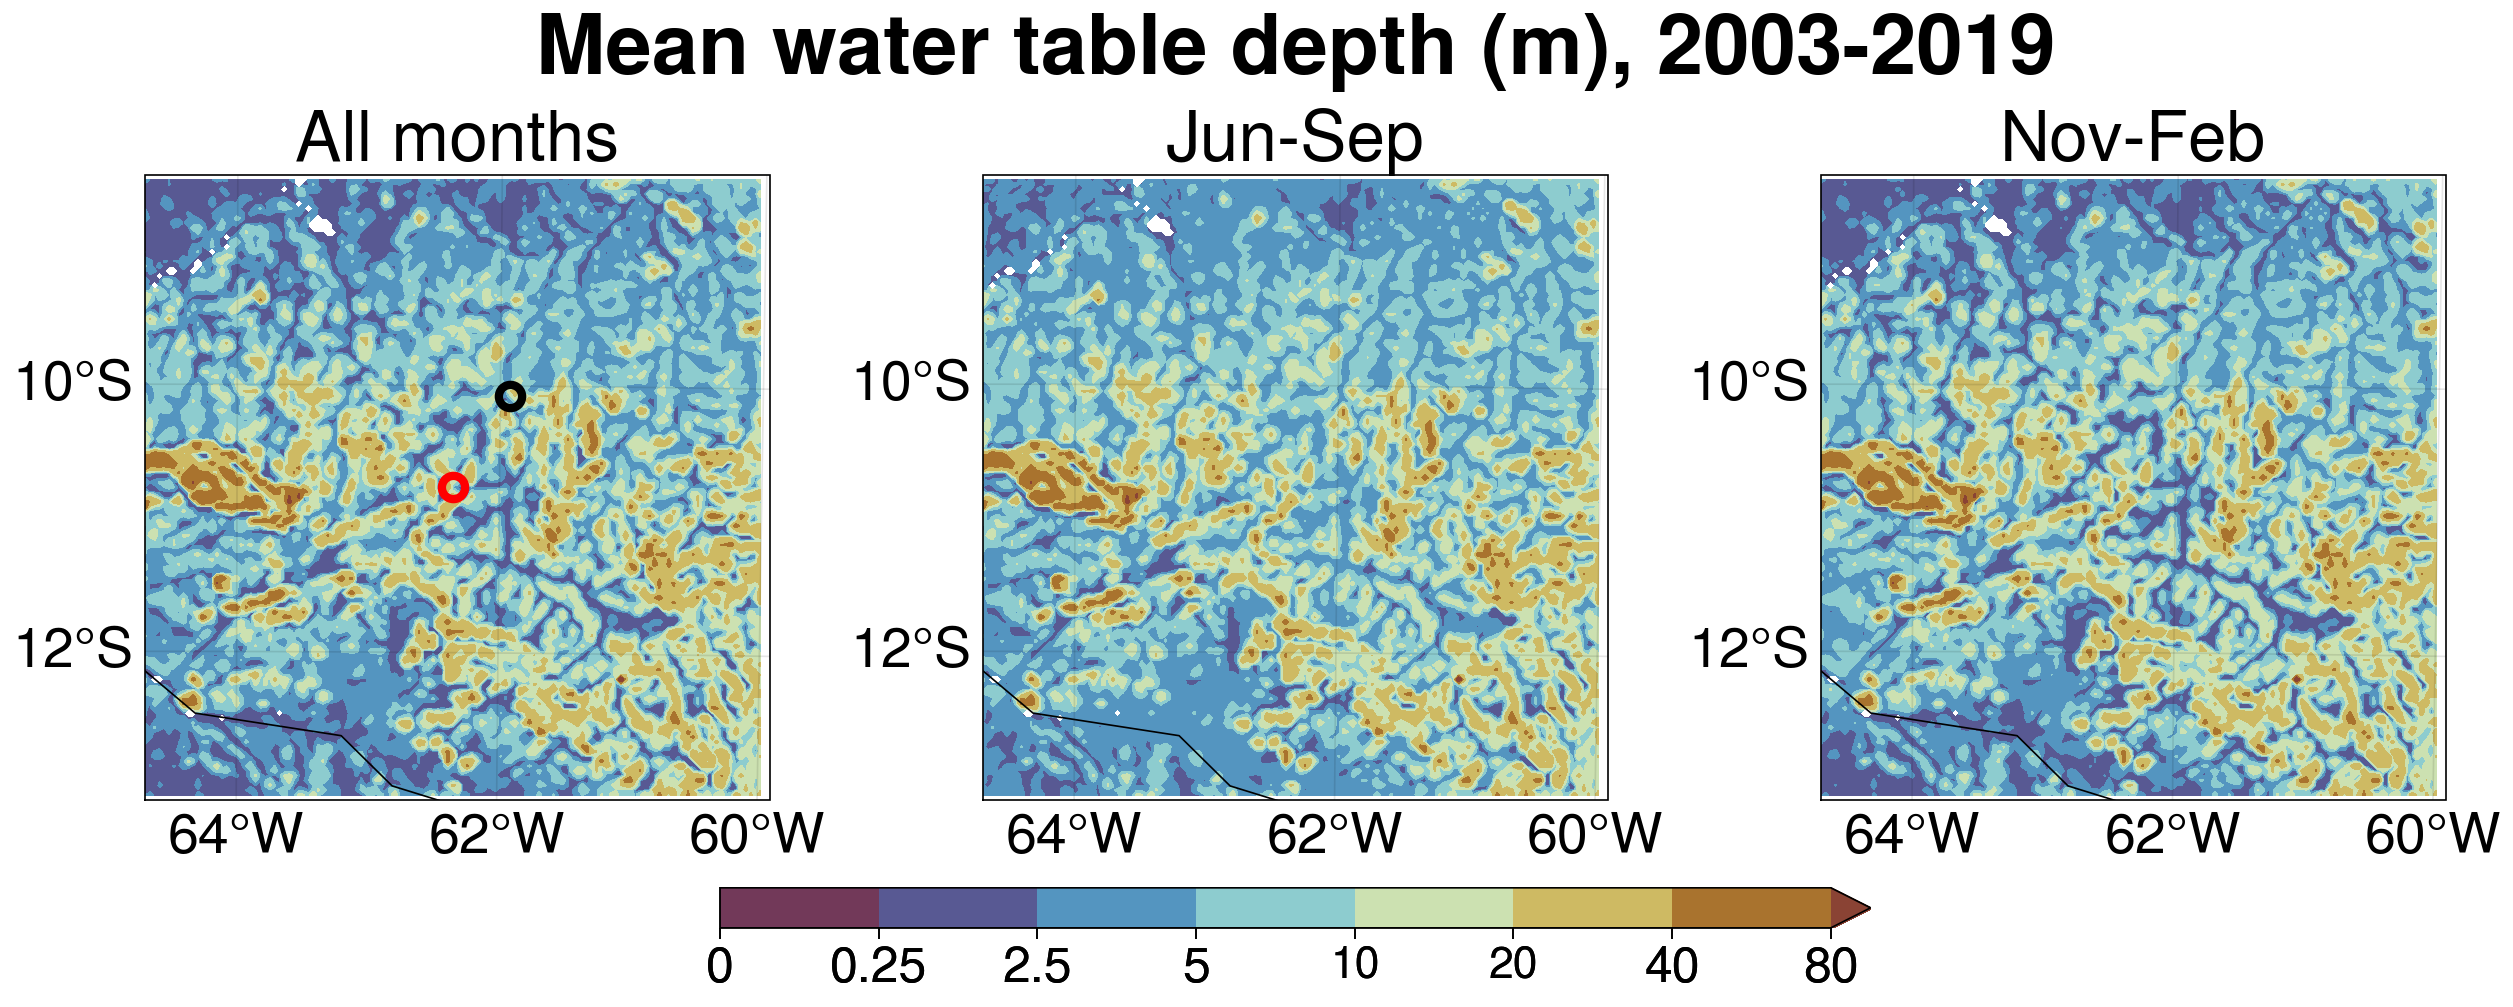

In [33]:
# Plot area figures of mean WTD from model output

# Create a figure
fig = pplt.figure(refwidth='25em')
# Set the GeoAxes to the projection used by WRF
ax = fig.subplots(ncols=3, projection=cart_proj)

cmap = mpl.colors.ListedColormap(pplt.get_colors('romaO_r',9))

levels = [0,0.25, 2.5, 5, 10, 20, 40, 80]
norm = mpl.colors.BoundaryNorm(levels,len(levels)-1)

m = ax[0].contourf(to_np(lons), to_np(lats), -1*zwtmean,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm, extend='max')

ax[0].scatter(to_np(lons[jbrx,jbry]),to_np(lats[jbrx,jbry]), marker='o', facecolor = 'None', edgecolor=markercolors[0], label='Forest', 
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())
ax[0].scatter(to_np(lons[fnsx,fnsy]),to_np(lats[fnsx,fnsy]), marker='o', facecolor = 'None',  edgecolor=markercolors[1], label='Savanna',
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())

ax[0].format(title='All months', titlesize=25)

m = ax[1].contourf(to_np(lons), to_np(lats), -1*zwtdry,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm, extend='max')
ax[1].format(title='Jun-Sep', titlesize=25)

m = ax[2].contourf(to_np(lons), to_np(lats), -1*zwtwet,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm, extend='max')
ax[2].format(title='Nov-Feb', titlesize=25)

ax.format(borders=True, lonlim=(lons.min(),lons.max()), latlim=(lats.min(), lats.max()), 
          suptitle='Mean water table depth (m), 2003-2019', suptitlesize=30, labels=True,
          ticklabelsize=20, lonlocator=(pplt.Locator('fixed',(-60,-62,-64))), latlocator=(pplt.Locator('fixed',(-10,-12))))

cb = fig.colorbar(m, loc='b', shrink=0.5, label='',ticklabelsize=18)
cb.set_ticks([0,0.25,2.5,5,10,20,40,80])

plt.show()

In [16]:
# Calculate proportion uptake in first 1 m
sum_first_1m = data['rootnew']['UPTAKE'][:,:,:,:3].sum(dim='soil_layers_stag')
sum_all = data['rootnew']['UPTAKE'].sum(dim='soil_layers_stag')
uptake1m = sum_first_1m/sum_all

In [17]:
# Calculate simulation mean uptake above 1 m, and also for dry and wet months
u1mean = uptake1m.where(data['rootnew']['ZWT'] > -150).mean(dim='date')

u1dry  = uptake1m.where(data['rootnew']['ZWT'] > -150).sel(date=is_jjas(data['rootnew']['date.month']))
u1dry  = u1dry.mean(dim='date')

u1wet  = uptake1m.where(data['rootnew']['ZWT'] > -150).sel(date=is_ndjf(data['rootnew']['date.month']))
u1wet  = u1wet.mean(dim='date')

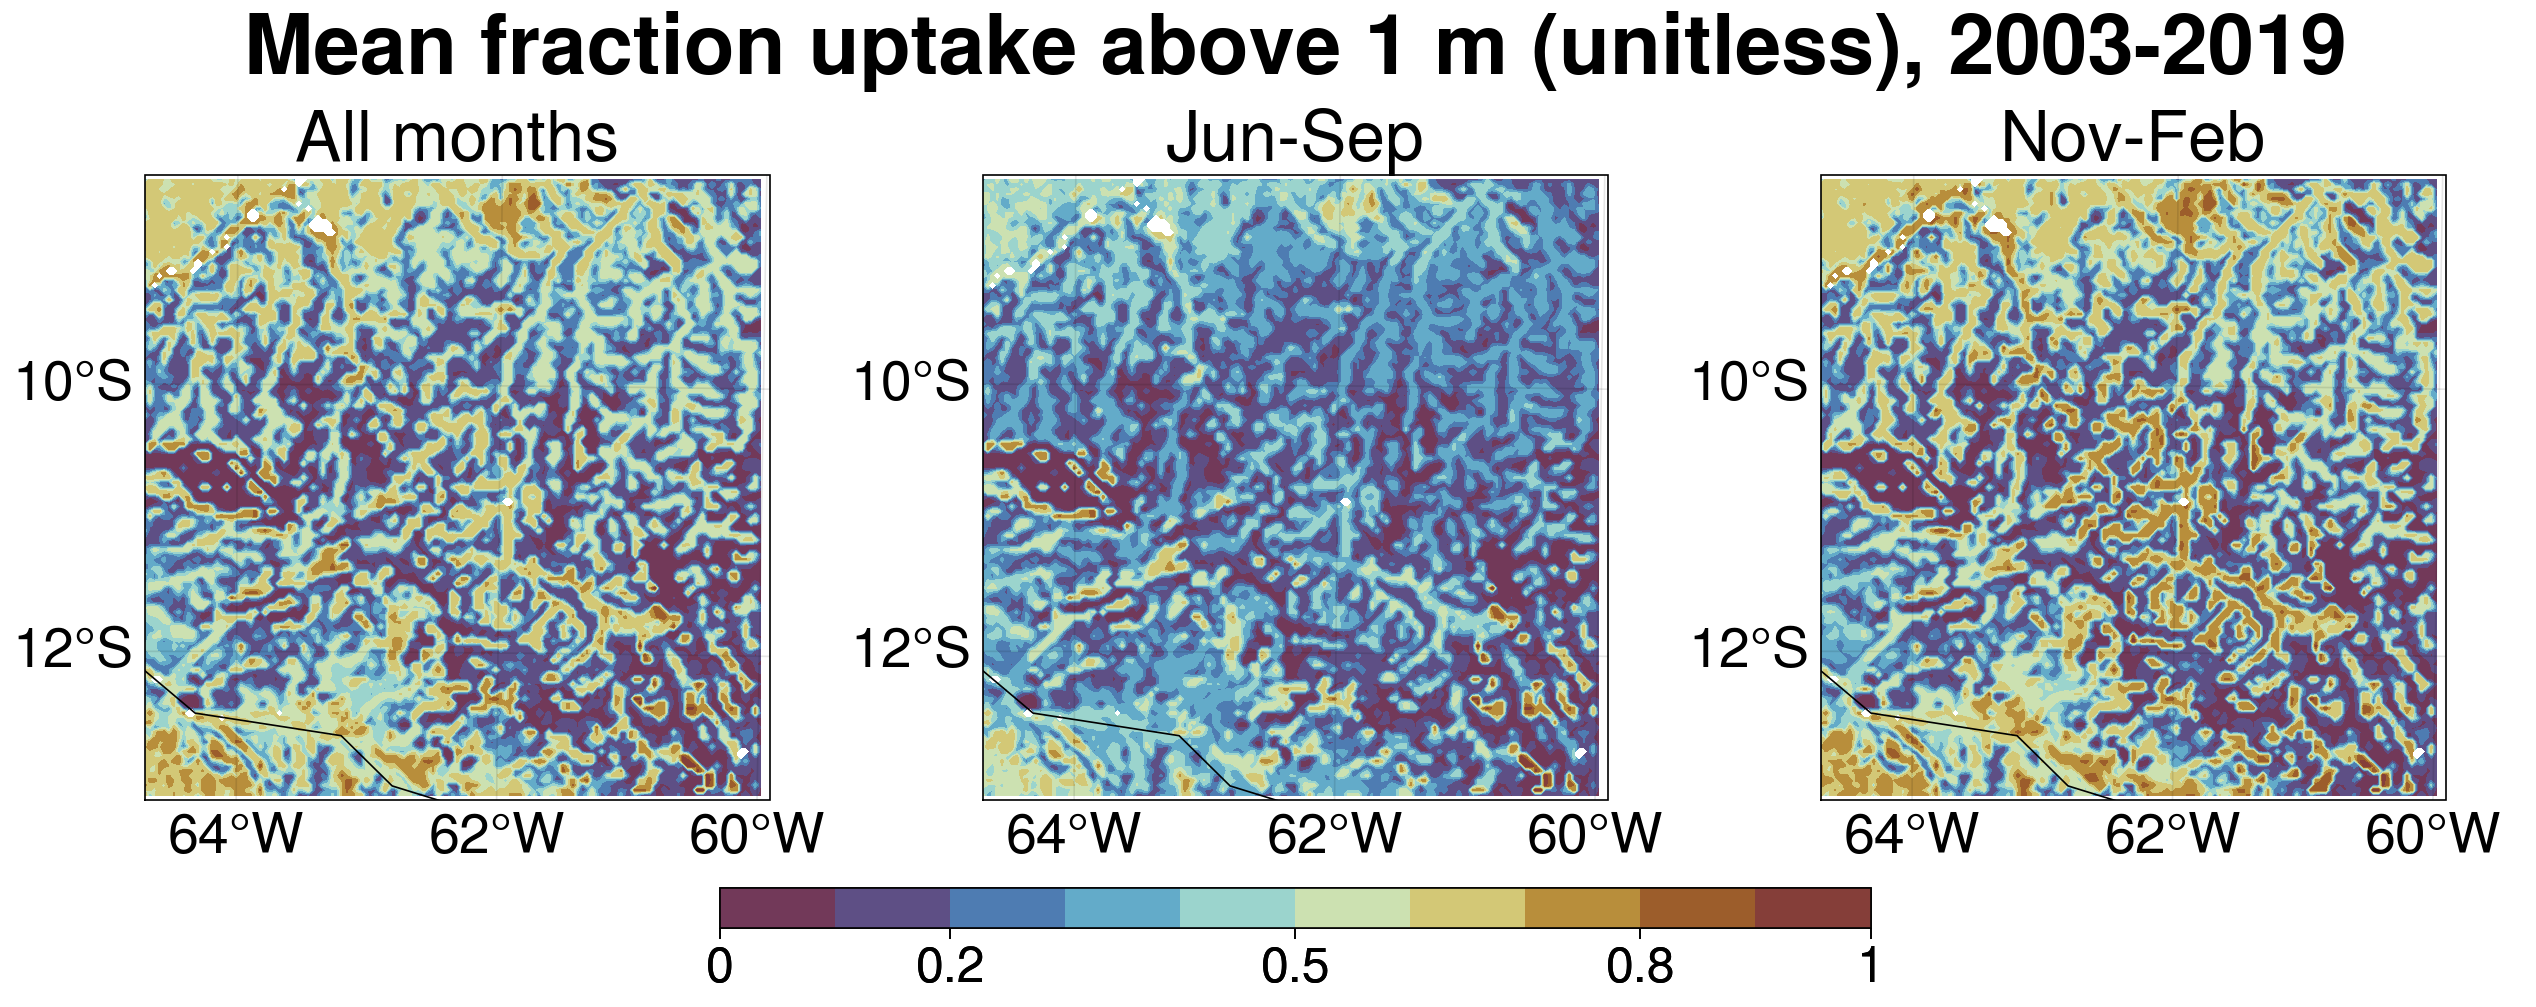

In [28]:
# Plot area figures of mean uptake above 1 m from ROOT case

# Create a figure
fig = pplt.figure(refwidth='25em')
# Set the GeoAxes to the projection used by WRF
ax = fig.subplots(ncols=3, projection=cart_proj)

cmap = mpl.colors.ListedColormap(pplt.get_colors('romaO_r',11))

levels = np.array((0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))
norm = mpl.colors.BoundaryNorm(levels,len(levels))

m = ax[0].contourf(to_np(lons), to_np(lats), u1mean,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm)
ax[0].format(title='All months', titlesize=25)

m = ax[1].contourf(to_np(lons), to_np(lats), u1dry,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm)
ax[1].format(title='Jun-Sep', titlesize=25)

m = ax[2].contourf(to_np(lons), to_np(lats), u1wet,
             transform=crs.PlateCarree(),
             cmap=cmap, norm=norm)
ax[2].format(title='Nov-Feb', titlesize=25)

ax.format(borders=True, lonlim=(lons.min(),lons.max()), latlim=(lats.min(), lats.max()), 
          suptitle='Mean fraction uptake above 1 m (unitless), 2003-2019', suptitlesize=30, labels=True, ticklabelsize=20,
          lonlocator=(pplt.Locator('fixed',(-60,-62,-64))), latlocator=(pplt.Locator('fixed',(-10,-12)))
          )

cb = fig.colorbar(m, loc='b', shrink=0.5, label='', ticklabelsize=18)
cb.set_ticks([0.0, 0.2, 0.5, 0.8, 1])

plt.show()

## Plot points and static domain variables

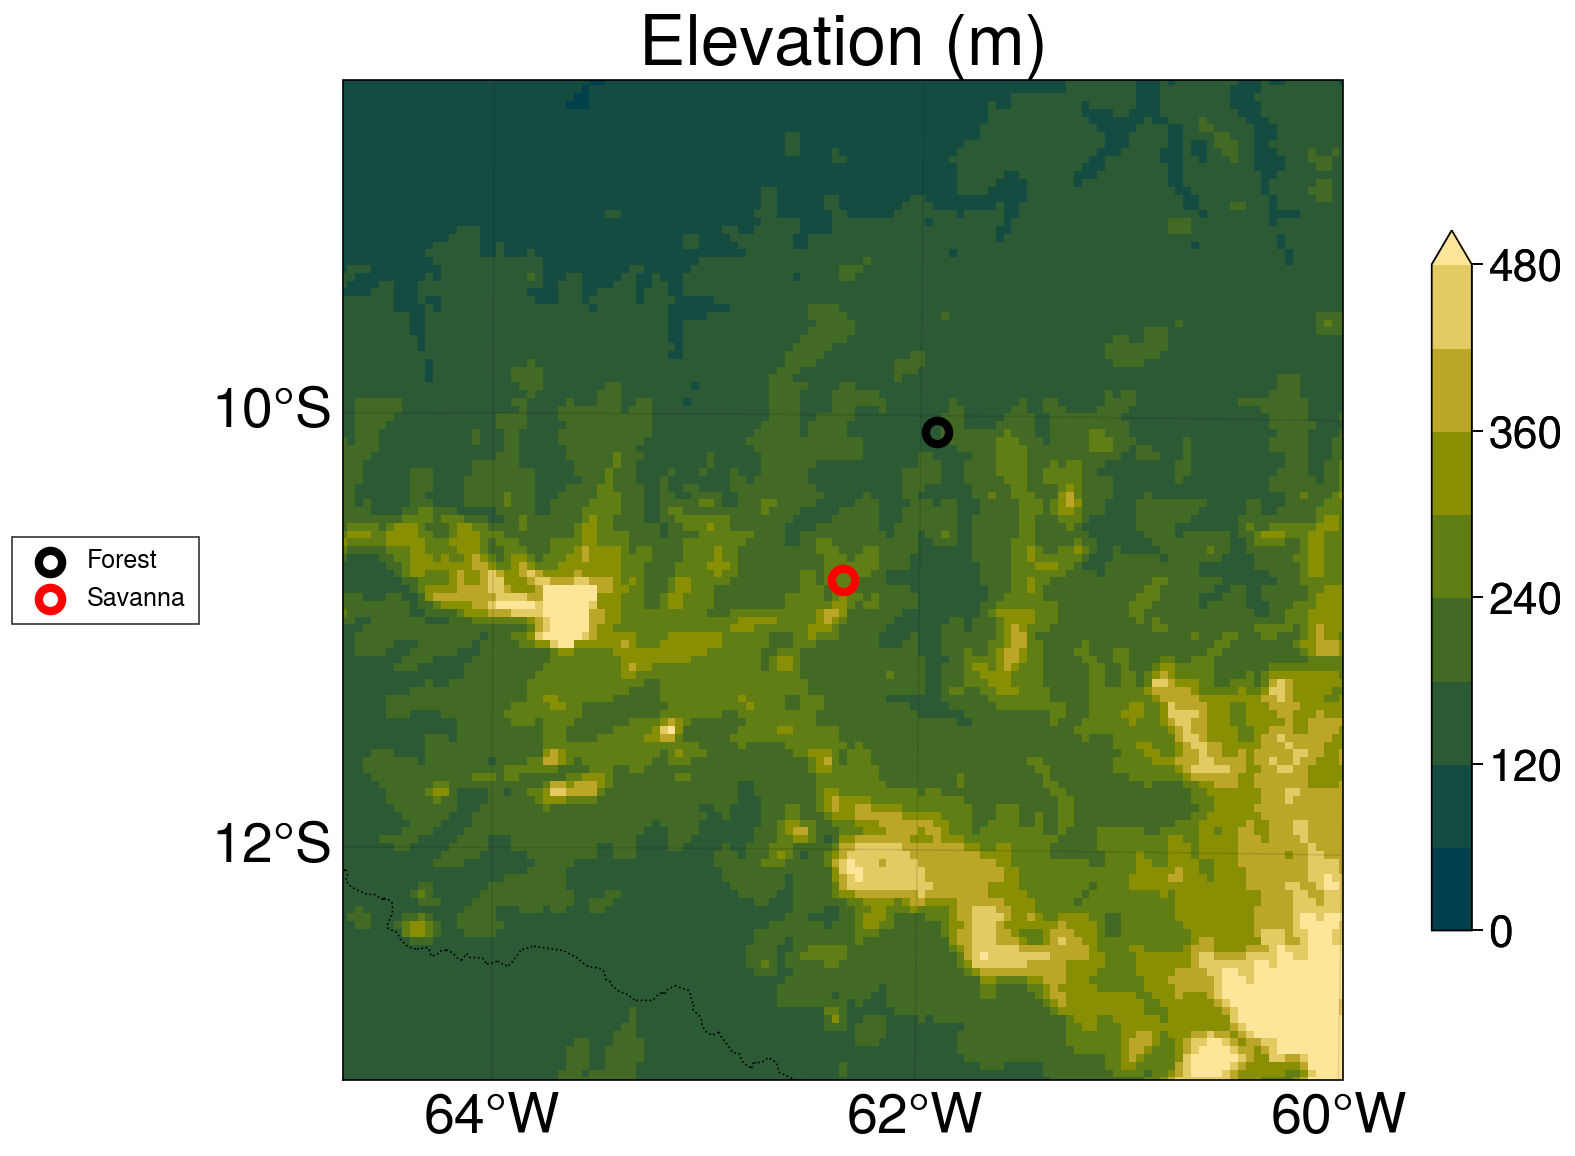

In [34]:
# Plot area figure of elevation used in simulations with forest and savanna grid points indicated

# Create a figure
fig = pplt.figure(refwidth='40em')
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=get_cartopy(topo))

pplt.rc['tick.labelsize'] = 16

#cmap=pplt.Colormap(('Dark Green' ,'Medium Green', 'Brown', 'Tan'))

pc = plt.pcolormesh(to_np(lons), to_np(lats), topo, cmap='bamako', transform=crs.PlateCarree(), vmin=0, vmax=500, 
                    levels=9, extend='max')

plt.scatter(to_np(lons[jbrx,jbry]),to_np(lats[jbrx,jbry]), marker='o', facecolor = 'None', edgecolor=markercolors[0], label='Forest', 
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())
plt.scatter(to_np(lons[fnsx,fnsy]),to_np(lats[fnsx,fnsy]), marker='o', facecolor = 'None',  edgecolor=markercolors[1], label='Savanna',
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())
plt.legend(loc='l',ncols=1)
cbar = plt.colorbar(pc, shrink=0.7, label='', ticks=[0,120,240,360,480])

ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_xlim(cartopy_xlim(topo))
ax.set_ylim(cartopy_ylim(topo))

ax.set_title('Elevation (m)', size=25)

ax.format(labels=True, lonlocator=(pplt.Locator('fixed',(-60,-62,-64))), 
          latlocator=(pplt.Locator('fixed',(-10,-12))), ticklabelsize=20)
          
plt.show()

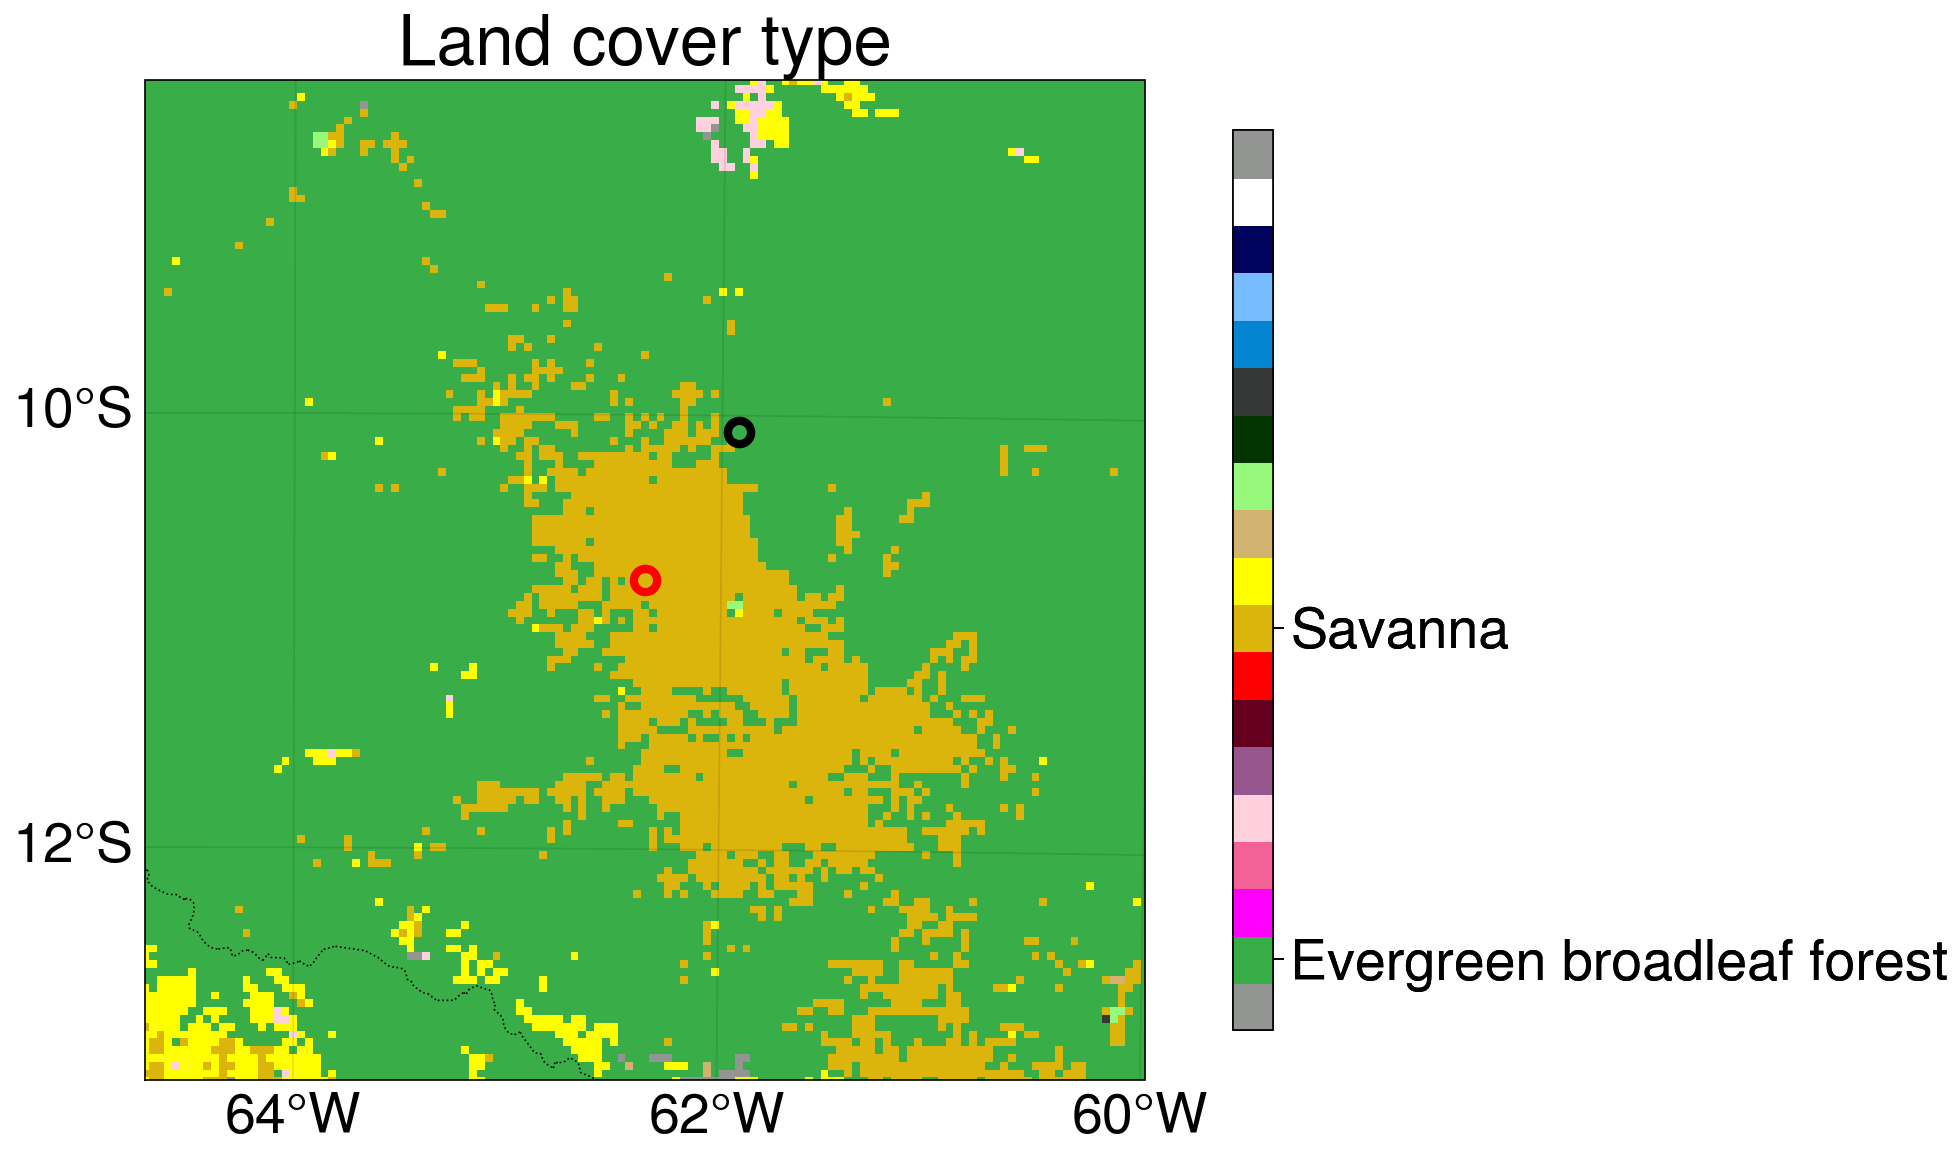

In [35]:
# Plot area figure of land cover type used in simulations with forest and savanna grid points indicated

# Create a figure
fig = pplt.figure(refwidth='40em')
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=get_cartopy(luse))

colors = ['grey','medium green','magenta','medium pink','light pink','purple','maroon','red','gold','yellow','tan','light green',
          'dark green', 'dark grey', 'cerulean', 'sky blue', 'dark blue','white','grey','blue','orange']

pc = plt.pcolormesh(to_np(lons), to_np(lats), luse, colors=colors,
                    transform=crs.PlateCarree(), 
                    levels=np.arange(1,21))

plt.scatter(to_np(lons[jbrx,jbry]),to_np(lats[jbrx,jbry]), marker='o', facecolor = 'None', edgecolor=markercolors[0], label='Forest', 
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())
plt.scatter(to_np(lons[fnsx,fnsy]),to_np(lats[fnsx,fnsy]), marker='o', facecolor = 'None',  edgecolor=markercolors[1], label='Savanna',
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())

cbar = plt.colorbar(pc, shrink=0.9, label='', ticks=[2.5,9.5,20.5], ticklabels=['Evergreen broadleaf forest',
                                                                                'Savanna', 'Water'], ticklabelsize=20)

ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_xlim(cartopy_xlim(luse))
ax.set_ylim(cartopy_ylim(luse))

ax.set_title('Land cover type', size=25)

ax.format(labels=True, lonlocator=(pplt.Locator('fixed',(-60,-62,-64))),
          latlocator=(pplt.Locator('fixed',(-10,-12))), ticklabelsize=20)

plt.show()

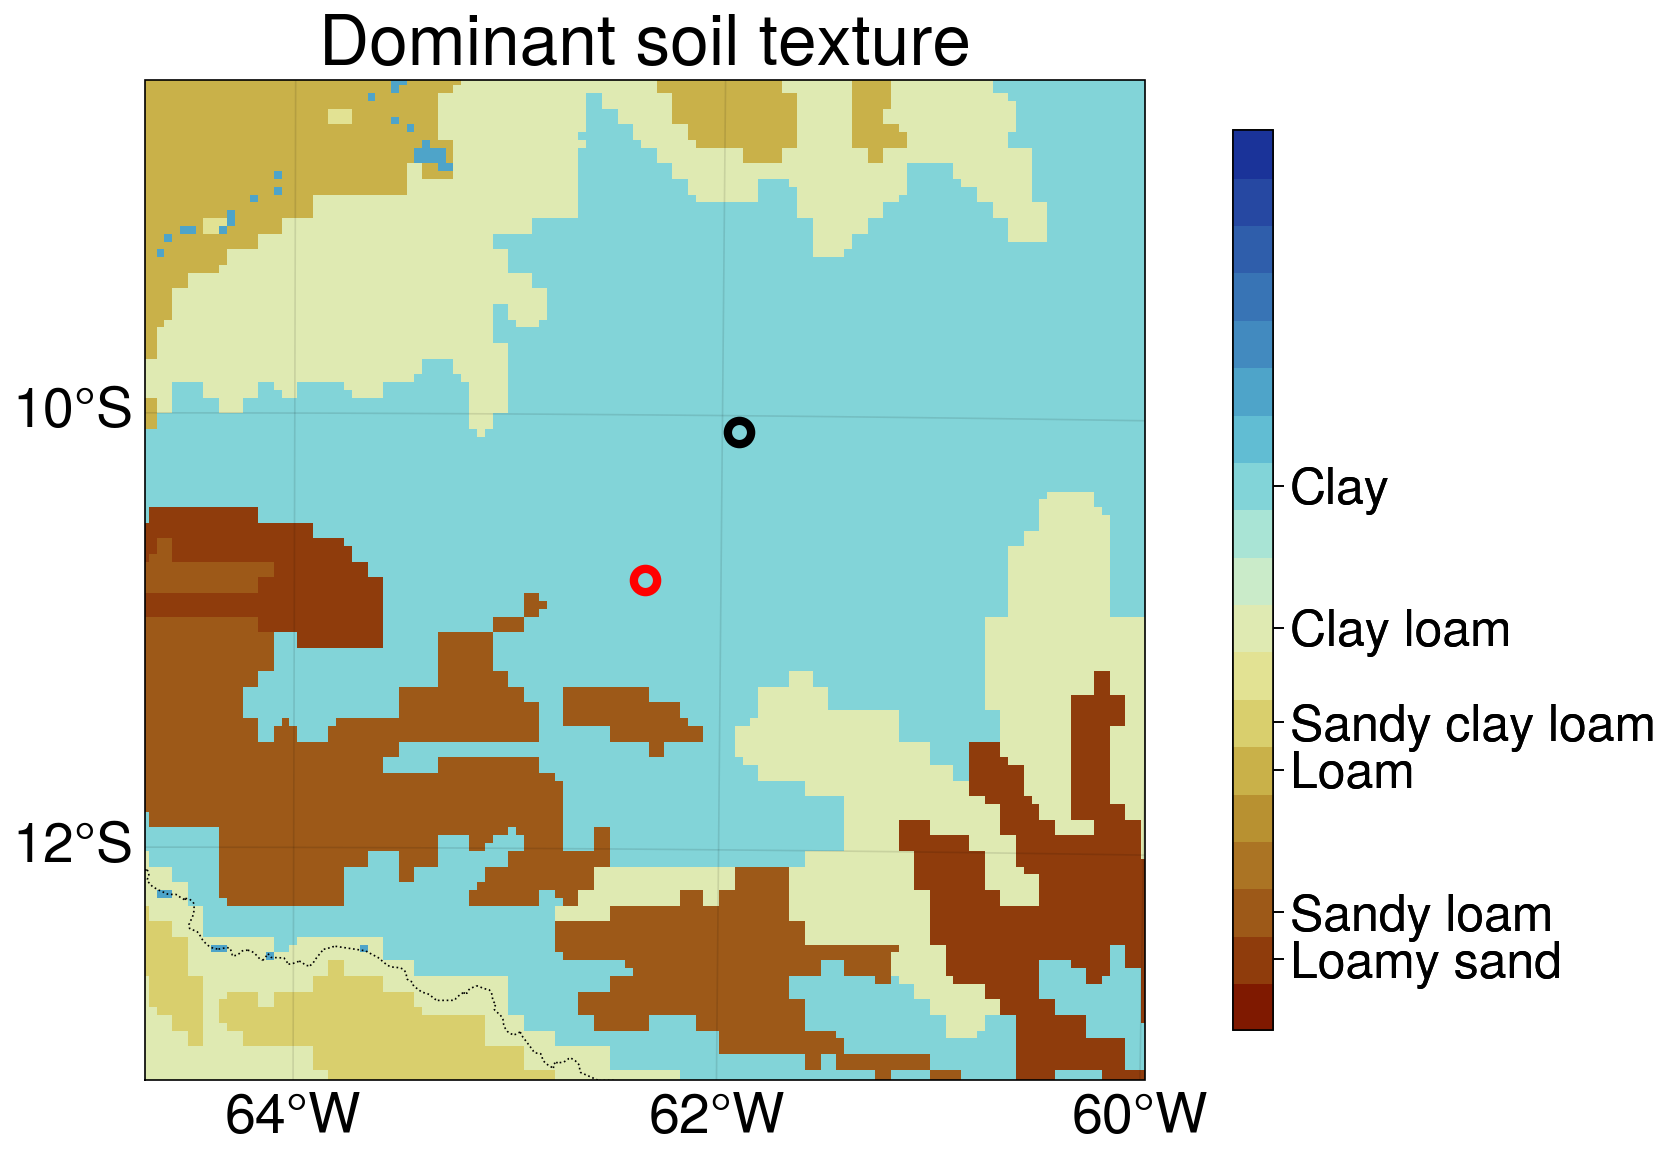

In [36]:
# Plot area figure of dominant soil type used in simulations with forest and savanna grid points indicated

# Create a figure
fig = pplt.figure(refwidth='40em')
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=get_cartopy(sltyp))

pc = plt.pcolormesh(to_np(lons), to_np(lats), sltyp, cmap='roma',
                    transform=crs.PlateCarree(), 
                    levels=np.arange(20))

plt.scatter(to_np(lons[jbrx,jbry]),to_np(lats[jbrx,jbry]), marker='o', facecolor = 'None', edgecolor=markercolors[0], label='Forest', 
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())
plt.scatter(to_np(lons[fnsx,fnsy]),to_np(lats[fnsx,fnsy]), marker='o', facecolor = 'None',  edgecolor=markercolors[1], label='Savanna',
         markersize=70, markeredgewidth=3, transform=crs.PlateCarree())

cbar = plt.colorbar(pc, shrink=0.9, label='', ticks=[1.5,2.5,5.5,6.5,8.5,11.5], ticklabelsize=18,
                    ticklabels=['Loamy sand', 'Sandy loam','Loam', 'Sandy clay loam', 'Clay loam', 'Clay'])

ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_xlim(cartopy_xlim(luse))
ax.set_ylim(cartopy_ylim(luse))

ax.set_title('Dominant soil texture', size=25)

ax.format(labels=True, lonlocator=(pplt.Locator('fixed',(-60,-62,-64))), 
          latlocator=(pplt.Locator('fixed',(-10,-12))), ticklabelsize=20)

plt.show()

## GLEAM

In [39]:
# Read in GLEAM data
get = xr.open_mfdataset('/glade/work/cab478/gleam/Et/Et*.nc') # Transpiration
ge  = xr.open_mfdataset('/glade/work/cab478/gleam/E_*.nc') # Evapotranspiration

##  Drydown analysis

In [2]:
def slpana(MAT,npix):
    '''
    This code calculates the Mann Kendall test for trend in a given variable for every pixel - if there is at least one value to be analyzed.
    '''
    
    trendl = []
    hl = []
    pl = []
    slopel = []
    sl = []
    for j in range(npix):
        selectarr = np.squeeze(MAT[j,:])

        #WE CAN ONLY DO MANN KENDAL WHEN THERE IS AT LEAST ONE NUMBER
        numnonan = selectarr[~np.isnan(selectarr)]
        if len(numnonan) > 1:
            res = mk.original_test(selectarr)
            trendl.append(res.trend)
            hl.append(res.h)
            pl.append(res.p)
            slopel.append(res.slope)
            sl.append(res.s)
            
        else:
            default = np.nan
            trendl.append(default)
            hl.append(default)
            pl.append(default)
            slopel.append(default)
            sl.append(default)
            

    trend = np.array(trendl)
    h = np.array(hl)
    p = np.array(pl)
    slope = np.array(slopel)
    S = np.array(sl)

    return trend, h, p, slope, S

In [37]:
# Get Noah-MP model transpiration or ET (comment top 2 lines and uncomment lower 2 lines for ET) for days 150-250 of the year in mm/day
dryTr = data['rootnew']['ETRAN'].groupby('date.dayofyear').mean('date').sel(dayofyear=slice(150,250))*86400.
dryTs = data['soil']['ETRAN'].groupby('date.dayofyear').mean('date').sel(dayofyear=slice(150,250))*86400.
#dryTr = (data['rootnew']['LH'].groupby('date.dayofyear').mean('date').sel(dayofyear=slice(150,250))/2.45e6)*86400.
#dryTs = (data['soil']['LH'].groupby('date.dayofyear').mean('date').sel(dayofyear=slice(150,250))/2.45e6)*86400.

In [40]:
# Get GLEAM transpiration data just for our domain and get day of year means for all years
get = get.sel(lat=slice(np.max(lats).values, np.min(lats).values)).sel(lon=slice(np.min(lons).values,np.max(lons).values)).groupby('time.dayofyear').mean()

In [24]:
# Get GLEAM ET data just for our domain and get day of year means for all years
ge = ge.sel(lat=slice(np.max(lats).values, np.min(lats).values)).sel(lon=slice(np.min(lons).values,np.max(lons).values)).groupby('time.dayofyear').mean()

In [41]:
# Select mean GLEAM transpiration for days 150-250 across all years
dryget = get.sel(dayofyear=slice(150,250))['Et']

In [27]:
# Select mean GLEAM ET for days 150-250 across all years
dryge = ge.sel(dayofyear=slice(150,250))['E']

In [42]:
# Get correct shape and dimension order
dryget =  dryget.transpose('lat','lon','dayofyear').values.reshape(18*19,101)

In [29]:
# Get correct shape and dimension order
dryge =  dryge.transpose('lat','lon','dayofyear').values.reshape(18*19,101)

In [43]:
# Neglect missing values, get correct shape and dimension order
dryTr = dryTr.where(dryTr>-1000)
dryTr = dryTr.transpose('lat','lon','dayofyear').values.reshape(129*129,101)

In [44]:
# Neglect missing values, get correct shape and dimension order
dryTs = dryTs.where(dryTs>-1000)
dryTs = dryTs.transpose('lat','lon','dayofyear').values.reshape(129*129,101)

In [45]:
# Apply Mann-Kendall test and calculate Theil-Sen slope!
LHtrendr, LHhr, LHpr, LHsloper, LHSr = slpana(dryTr,129*129)
LHtrends, LHhs, LHps, LHslopes, LHSs = slpana(dryTs,129*129)
LHtrendg, LHhg, LHpg, LHslopeg, LHSg = slpana(dryget,18*19)

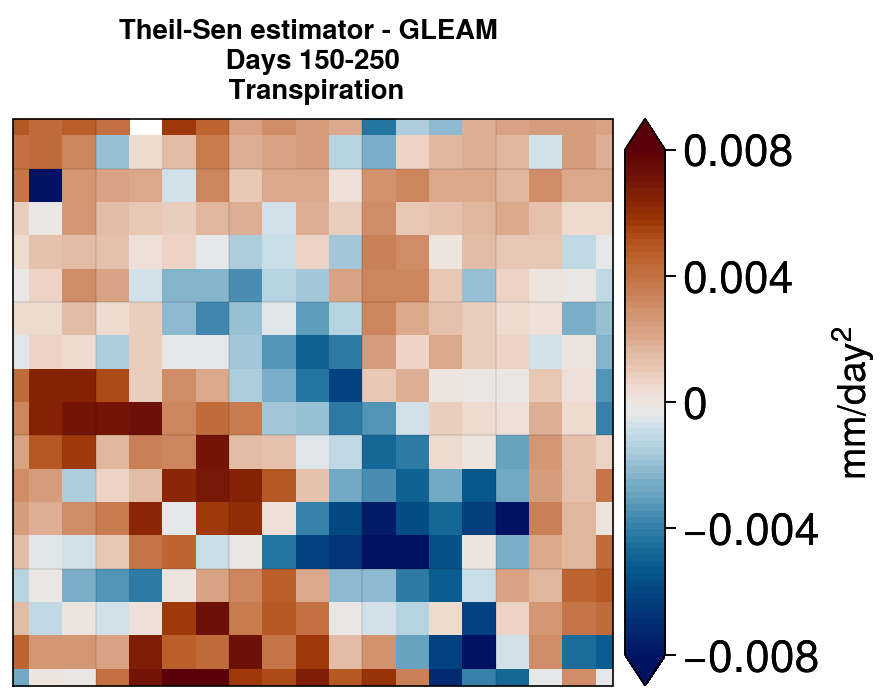

In [55]:
# Plot Theil-Sen slope for GLEAM transpiration

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj='cyl')

p = axs.pcolormesh(get.lon.values, get.lat.values, LHslopeg.reshape(18,19), vmin=-0.008, vmax=0.008, cmap='vik', extend='both',levels=100)
axs.colorbar(p, ticks=0.004, label='$mm/day^{2}$', labelsize=14)

axs.format(
    suptitle='Theil-Sen estimator - GLEAM \n Days 150-250 \n Transpiration',
    lonlim=(np.min(get.lon), np.max(get.lon)), latlim=(np.min(get.lat), np.max(get.lat)),
)


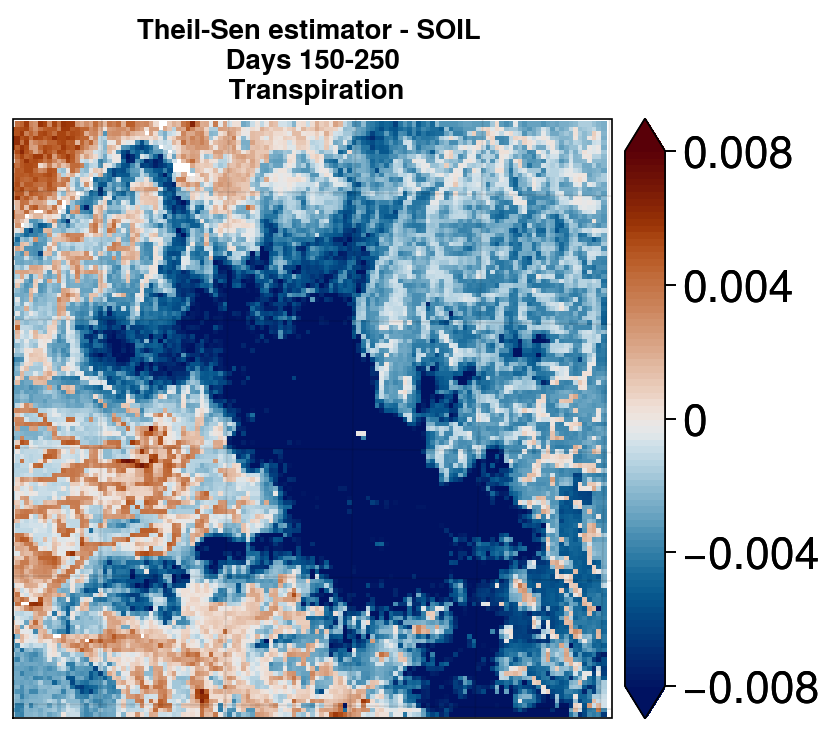

In [48]:
# Plot Theil-Sen slope for Noah-MP model transpiration from SOIL case

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj=cart_proj)

p = axs.pcolormesh(lons, lats, LHslopes.reshape(129,129), vmin=-0.008, vmax=0.008, cmap='vik', extend='both', levels=100, transform=crs.PlateCarree()) 
axs.colorbar(p, ticks=0.004)

axs.format(
    suptitle='Theil-Sen estimator - SOIL \n Days 150-250 \n Transpiration',
    lonlim=(np.min(lons), np.max(lons)), latlim=(np.min(lats), np.max(lats))
)


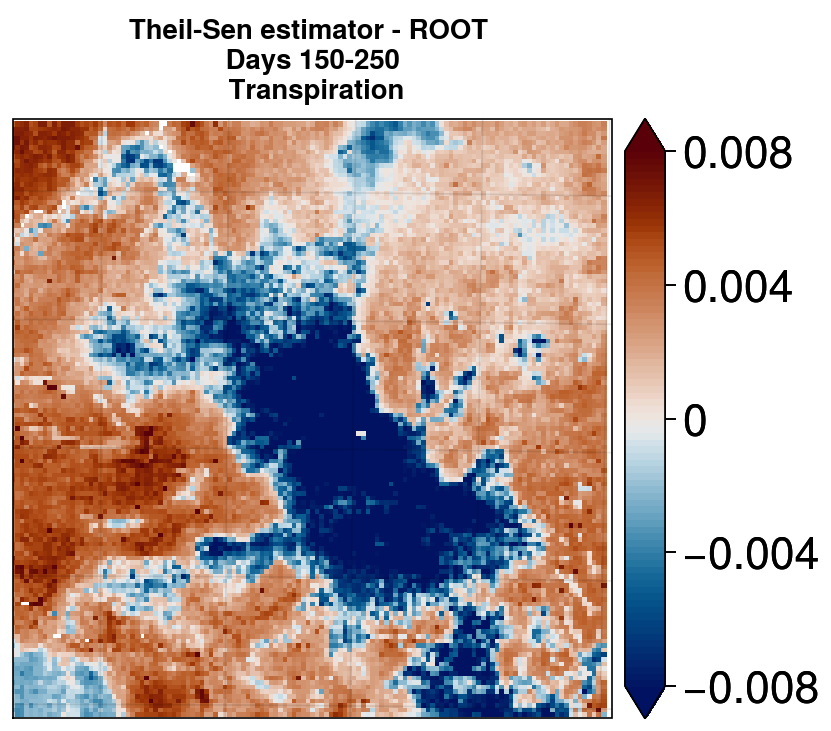

In [49]:
# Plot Theil-Sen slope for Noah-MP model transpiration from ROOT case

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj=cart_proj)

p = axs.pcolormesh(lons, lats, LHsloper.reshape(129,129), vmin=-0.008, vmax=0.008, cmap='vik', extend='both', levels=100, transform=crs.PlateCarree())
axs.colorbar(p,  ticks=0.004)

axs.format(
    suptitle='Theil-Sen estimator - ROOT \n Days 150-250 \n Transpiration',
    lonlim=(np.min(lons), np.max(lons)), latlim=(np.min(lats), np.max(lats)),
)


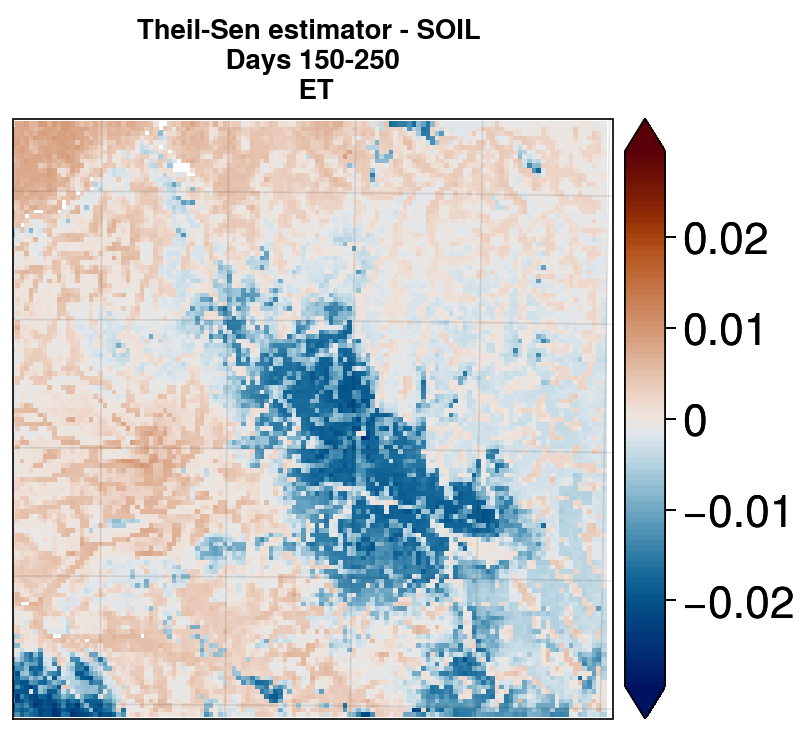

In [33]:
# Plot Theil-Sen slope for Noah-MP model ET from SOIL case

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj=cart_proj)

p = axs.pcolormesh(lons, lats, LHslopes.reshape(129,129), vmin=-0.03, vmax=0.03, cmap='vik', extend='both', levels=100, transform=crs.PlateCarree()) #vmin=-0.01, vmax=0.01,
axs.colorbar(p, ticks=0.01)

axs.format(
    suptitle='Theil-Sen estimator - SOIL \n Days 150-250 \n ET',
    lonlim=(np.min(lons), np.max(lons)), latlim=(np.min(lats), np.max(lats))
)


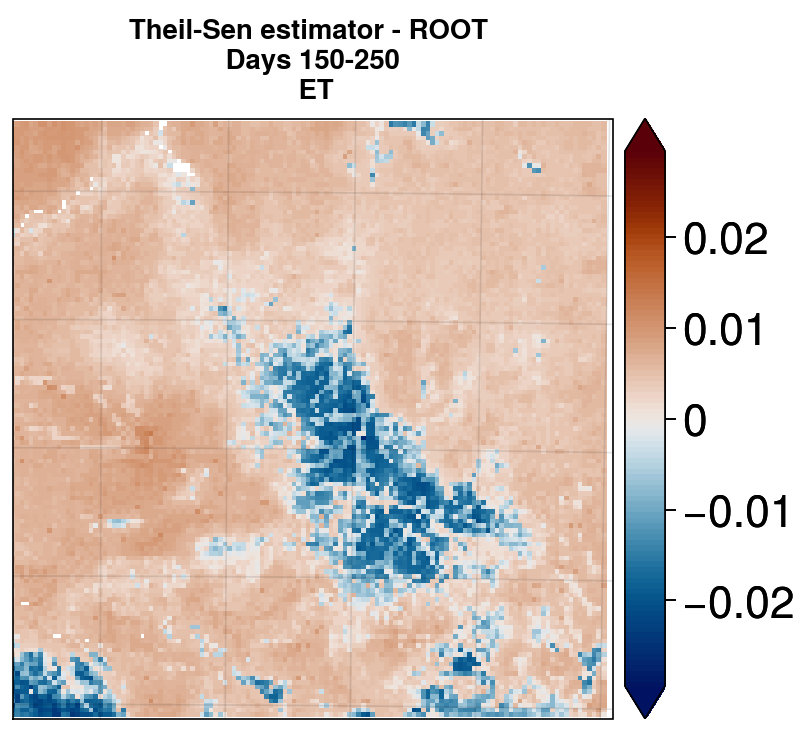

In [34]:
# Plot Theil-Sen slope for Noah-MP model ET from ROOT case

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj=cart_proj)

p = axs.pcolormesh(lons, lats, LHsloper.reshape(129,129), vmin=-0.03, vmax=0.03, cmap='vik', extend='both', levels=100, transform=crs.PlateCarree())
axs.colorbar(p,  ticks=0.01)

axs.format(
    suptitle='Theil-Sen estimator - ROOT \n Days 150-250 \n ET',
    lonlim=(np.min(lons), np.max(lons)), latlim=(np.min(lats), np.max(lats)),
)


In [ ]:
# Plot Theil-Sen slope for GLEAM ET 

fig = pplt.figure(refwidth=3)
axs = fig.subplots(nrows=1, proj='cyl')

p = axs.pcolormesh(ge.lon.values, ge.lat.values, LHslopeg.reshape(18,19), vmin=-0.03, vmax=0.03,  cmap='vik', extend='both',levels=100)
axs.colorbar(p, ticks=0.01,label='$mm/day^{2}$',labelsize=14)

axs.format(
    suptitle='Theil-Sen estimator - GLEAM \n Days 150-250 \n ET',
    lonlim=(np.min(ge.lon), np.max(ge.lon)), latlim=(np.min(ge.lat), np.max(ge.lat)),
)
